# PIV analysis

Fabian Krautgasser, Jasmin Di Franco - https://somexlab.github.io/

This code is based on the use of http://www.openpiv.net/

## dynamical heterogeneity, correlation lengths, alignment, order parameter

The following notebook is a compact version of the relevant results obtained by PIV analysis. In here we'll 
1. read from a common config file the relevant PIV information
    1. setup folder structure
    2. Read image files
    3. If configured, preprocess images e.g. w/ registration
3. Perform PIV + store results + generate example velocity field plots
4. derive quantities like RMS velocities 
5. calculate correlation functions & correlation lengts
6. perform analysis of dynamical heterogeneities based on the cluster size of the fastest 20%
7. shine some light on the cell alignment in terms of velocity vectors
8. investigate the order parameter

## Global variable settings

Enter the config file corresponding to the experiment you want to analyse in the `configpath` variable.

If the setting `comparison_plots` is set to `True`, do not forget to set the variable `compare` to either `hacat_cmp`, `utscc11_cmp` or `utscc103_cmp`. This maps the list of comparison results to the `compare` variable, which is used below in the comparison plots.

The `treatment_map` dictionary just maps the folder names to proper $\LaTeX\$-labels.

In [151]:
configpath = "utscc103-a3.toml"
overwrite = False  # overwrite results, i.e. reprocess everything
process_images = False
multiple_velocity_maps = False

comparison_plots = True

hacat_cmp = [
    # "HaCaT/a3-reg",
    "HaCaT/a3",
    # "HaCaT/a6-reg",
    "HaCaT/a6",
    # "HaCaT/a3a6-reg",
    "HaCaT/a3a6",
    # "HaCaT/Mab13-reg",
    "HaCaT/Mab13",
    "HaCaT/cntrl"
]

utscc11_cmp = [ 
    "UT-SCC-11/a3",
    "UT-SCC-11/a6",
    "UT-SCC-11/a3a6",
    "UT-SCC-11/Mab13",
    "UT-SCC-11/cntrl"
]

utscc103_cmp = [ 
    # "UT-SCC-103/a3-reg",
    "UT-SCC-103/a3",
    # "UT-SCC-103/a6-reg",
    "UT-SCC-103/a6",
    # "UT-SCC-103/a3a6-reg",
    "UT-SCC-103/a3a6",
    "UT-SCC-103/Mab13",
    # "UT-SCC-103/cntrl-reg"
    "UT-SCC-103/cntrl"
]


compare = utscc103_cmp #utscc11_cmp # hacat_cmp
treatment_map = {
    "a3a6": r"$\alpha_3 \alpha_6$",
    "a3": r"$\alpha_3$",
    "a6": r"$\alpha_6$",
    "Mab13": r"$\beta_1$",
    "cntrl": "IgG"
}


## Setup
### Packages & function definitions

In [152]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import trackpy as tp
import skimage.io as io
import lmfit as lm
import toml as to
import skimage
# import importlib_resources

from pprint import pprint
from multiprocessing import Pool
from pathlib import Path
from typing import Optional, Any
from functools import partial

from fastddm.utils import chunkify
from openpiv import tools, pyprocess, validation, filters, scaling
from fastddm import read_images
from pystackreg import StackReg


rc = {
    "text.usetex": True,
    "figure.dpi": 300,  
    "font.sans-serif":  ['Linux Biolinum'],# ['Helvetica']
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    # "svg.fonttype": 42
}
#import matplotlib
#matplotlib.rcParams['pdf.fonttype'] = 42
#matplotlib.rcParams['ps.fonttype'] = 42

sns.set(rc=rc)
# sns.set_context("notebook", rc={'text.usetex': True})
sns.set_context("paper", rc=rc)
sns.set_style("ticks", rc=rc)
sns.set_palette("muted")

%matplotlib inline

In [153]:
def read_config(path: Path, verbose: bool = False) -> dict[str, Any]:
    """Read simple toml config."""
    with open(path) as tomlfile:
        config = to.load(tomlfile)
    if "use_every" not in config['piv-proc'].keys():
        config['piv-proc']['use_every'] = 1
    
    if verbose:
        import pprint
        pprint.pprint(config)
    return config


def impaths(config: dict[str, Any]) -> list[Path]:
    """Read image paths from given config."""
    parent = Path(config["BASEPATH"]) / config['src']
    impaths = list(sorted(parent.glob(config['glob'])))
    
    return impaths
    

def create_streamplot(ax, x, y, u, v, color = None, cmap = None, colorbar = False, vmin = None, vmax = None, density = 2, linewidth = 0.7, arrowsize = 0.7,):
    """Create a streamplot with some defaults set."""
    
    if color is None:
        color = np.sqrt(u**2 + v**2)
    if cmap is None:
        cmap = plt.cm.Reds
    
    if vmin is not None and vmax is not None:
        from matplotlib.colors import Normalize
        norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        norm = None

    sp = ax.streamplot(
        x, y, u, v,
        color=color,
        cmap=cmap,
        norm=norm,
        density=density, 
        linewidth=linewidth, 
        arrowsize=arrowsize
    )

    if colorbar:
        return ax, sp, plt.colorbar(sp.lines, ax=ax)

    return ax, sp, None

def create_quiverplot(ax, x, y, u, v, color = None, cmap = None, colorbar = False, vmin = None, vmax = None):
    """Create a quiverplot with some defaults set."""
    if color is None:
        color = np.sqrt(u**2 + v**2)
    if cmap is None:
        cmap = plt.cm.Reds

    if vmin is not None and vmax is not None:
        from matplotlib.colors import Normalize
        norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        norm = None
    
    qu = ax.quiver(
        x, y, u, v,
        color,
        cmap=cmap,
        norm=norm
    )

    if colorbar:
        return ax, qu, plt.colorbar(qu, ax=ax)

    return ax, qu, None

def piv(im1: np.ndarray, im2: np.ndarray, params: dict[str, Any], verbose: bool = False) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Perform PIV on the two images with given parameters. Returns the resulting coordinates and  u and v vectors."""
    # sanitize params
    if params["searchsize"] is None:
        params["searchsize"] = int(params["winsize"] * 1.2)

    if params["overlap"] is None:
        params["overlap"] = int(params["winsize"] / 2)

    # initial PIV calculation    
    u0, v0, sig2noise = pyprocess.extended_search_area_piv(
        im1.astype(np.int32),
        im2.astype(np.int32),
        window_size=params["winsize"],
        overlap=params["overlap"],
        dt=params["dt"],
        search_area_size=params["searchsize"],
        sig2noise_method=params["sig2noise_method"]
    )

    # get coordinates of interrogation window
    x, y = pyprocess.get_coordinates(
        image_size=im1.shape,
        search_area_size=params["searchsize"],
        overlap=params["overlap"],
    )
    
    # create mask for outliers
    invalid_mask = validation.sig2noise_val(sig2noise, threshold=params["threshold"])

    # replace outliers and substitute with average of neighbouring values
    u2, v2 = filters.replace_outliers(u0, v0, invalid_mask, **params["replace_outliers"])

    # calculate scaling factor to milimiters 
    # pixel_size is always microns / px
    scaling_factor = 1/(params["pixel_size"]) * 1e3  # px/mm
    if verbose:
        print(f":: scaling factor={scaling_factor} px/mm")

    # scale coordinates and velocities
    x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor=scaling_factor)

    return x, y, u3, v3


def piv_movie(mov: np.ndarray, params: dict[str, Any], verbose: bool = False):
    """Perform PIV on a whole movie."""
    x, y, _u, _v = piv(mov[0], mov[1], params)
    u, v = np.zeros((2, len(mov), *_u.shape))
    u[0] = _u[:]
    v[0] = _v[:]

    for i in range(1, len(mov)-1):
        if verbose:
            if i % 100 == 0:
                print(f"  --> @ image {i}")
        _x, _y, _u, _v = piv(mov[i], mov[i+1], params)
        u[i] = _u[:]
        v[i] = _v[:]

    return x, y, u, v

def full_piv(dataset: np.ndarray, params: dict[str, Any], ncpus: Optional[int] = None, verbose: bool = False):
    """Perform PIV on a whole dataset (i.e. a collection of FOVs), in parallel."""
    if ncpus is None:
        ncpus = len(dataset)

    piv_func = partial(piv_movie, params=params, verbose=verbose)

    with Pool(ncpus) as p:
        result = p.map(piv_func, dataset)
    
    # result is a list of the return tuples of piv_movie
    # x and y should be the same for all of them
    x, y = result[0][:2]
    u = np.zeros((len(dataset), *result[0][2].shape))
    v = np.zeros_like(u)

    for i in range(len(dataset)):
        u[i] = result[i][2]
        v[i] = result[i][3]
    
    return x, y, u, v


def drift_correct(velocity: np.ndarray) -> np.ndarray:
    """Correct for overall drift in the velocities. 
    
    Assumed input dimension is (FOV, frame, y, x).
    """
    v_star = np.zeros_like(velocity)
    for f in range(len(velocity)):
        for i in range(len(velocity[f])):
            v_star[f, i] = velocity[f, i] - velocity[f, i].mean()

    return v_star

def rms_velocity(u: np.ndarray, v: np.ndarray, chunks: Optional[list[np.ndarray]] = None) -> np.ndarray:
    """Computes the FOV-averaged rms velocity per frame vrms = sqrt(u**2 + v**2) and its standard deviation.
    
    Assumes shape (FOV, frame, y, x).
    If `chunks` is given, returns the v_rms averaged for each chunk.
    """
    if chunks is None:
        vrms = np.sqrt(np.nanmean(u**2 + v**2, axis=(2, 3))).mean(axis=0)
        std = np.sqrt(np.nanstd(u**2 + v**2, axis=(2, 3))).mean(axis=0)
        return vrms, std
        
    vrms = np.array(
        [np.sqrt(np.nanmean(v[:, ch]**2 + u[:, ch]**2, axis=(2, 3))).mean() for ch in chunks]
    )
    std = np.array([np.sqrt(np.nanstd(v[:, ch]**2 + u[:, ch]**2, axis=(2, 3))).mean() for ch in chunks]) 

    return vrms, std


def store_piv_data(storepath, x, y, u, v, ustar, vstar, config) -> None:
    """Store the given data in `storepath` as pickle file."""
    pd.to_pickle(
        {
            "x": x,
            "y": y,
            "u": u,
            "v": v,
            "u*": ustar,
            "v*": vstar,
            # "config": config
        },
    storepath
    )


def _stackreg_with_dtype(movie: np.ndarray, sr: StackReg) -> np.ndarray:
        return sr.register_transform_stack(movie).astype(np.int64)

def register_stack(stack: np.ndarray, kind: Optional[int] = None, ncpus: Optional[int] = None) -> np.ndarray:
    """Perform image registration on a whole stack. Default for kind is Translation.
    Assumed shape of `stack` is (FOV, T, Y, X).
    """
    kind = kind if kind is not None else StackReg.TRANSLATION
    ncpus = ncpus if ncpus is not None else len(stack)
    
    sr = StackReg(kind)
    fixed_sr = partial(_stackreg_with_dtype, sr=sr)

    with Pool(ncpus) as p:
        result = p.map(fixed_sr, stack)

    
    return np.array(result)

def color_space( 
    length: int,
    colormap: plt.cm.colors.LinearSegmentedColormap = plt.cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))


## 1. Load config

In [154]:
config = read_config(Path(configpath), verbose=True)

{'BASEPATH': '/home/fabian/data/ext_fabio_data/unified_input/archive/jasmin_kaivola/24h_Jam/',
 'chunk_length': 20,
 'chunk_overlap': 10,
 'every': 1,
 'glob': '*.tif',
 'info': 'UT-SCC-103 a3',
 'method': 'trackpy',
 'piv': {'dt': 600,
         'overlap': 40,
         'pixel_size': 1.62,
         'replace_outliers': {'kernel_size': 3,
                              'max_iter': 3,
                              'method': 'localmean'},
         'searchsize': 80,
         'sig2noise_method': 'peak2peak',
         'threshold': 1.2,
         'winsize': 66},
 'piv-proc': {'chunk_length': 10,
              'chunk_overlap': 5,
              'clahe': False,
              'nbins': 14,
              'prefactor_ddm_vel': 1.0,
              'register': False,
              'skip_first': 0,
              'use_every': 1},
 'pixel_size': 1.62,
 'pixel_size_unit': 'µm',
 'plotpath': 'UT-SCC-103',
 'results': {},
 'skip_first': 0,
 'src': 'G2_2/',
 'type': 'a3'}


### A. Folder structure

In [ ]:
#define here the folder structure according to the Data Management Plan

base = Path(".") / "piv" / config['plotpath'] / config['type']
plotpath = base / "plots"
datapath = base / "data"

for p in [base, plotpath, datapath]:
    p.mkdir(parents=True, exist_ok=True)

### B. Read image files

In [156]:
movies = impaths(config)
skip_first = config['piv-proc']['skip_first']
use_every = config['piv-proc']['use_every']

fovs = list(sorted(set(p.parent.name.replace("_", "\_") for p in movies)))
images = np.array(
    [read_images(p.as_posix())[skip_first::use_every] for p in movies]
)


if images.shape[0] == 1:
    images = images[0]

### we need to convert the RGB to grayscale

In [157]:
def rgb_to_gray(img: np.ndarray) -> np.ndarray:
    """Assumes img shape to be (T, Y, X, C)."""
    gray = (
        img[:, :, :, 0] * 0.299 + \
        img[:, :, :, 1] * 0.587 + \
        img[:, :, :, 2] * 0.114
    )

    return gray

images = rgb_to_gray(images)
images = images.reshape((1, *images.shape))  # we only have one FOV
images.shape

(1, 141, 936, 1264)

In [158]:
# enrich config with image dimension information
shape = images.shape[-2:]  # y, x
print("image dimensions:", shape)

config['shape'] = shape

image dimensions: (936, 1264)


### C. Pre-process images

In [159]:
if process_images and "register" in config['piv-proc'].keys() and config['piv-proc']['register']:
    images = register_stack(images, ncpus=3)

## 2. Perform PIV

### PIV on all FOVs (parallel)

In [160]:
datafile = datapath / "piv-results.pkl"

if overwrite or not datafile.exists(): 
    print(":: Either overwrite=True or data does not exist yet. Creating ...") 
    x, y, u, v = full_piv(images, config['piv'], verbose=True)
    u_star, v_star = drift_correct(u), drift_correct(v)
    store_piv_data(datafile, x, y, u, v, u_star, v_star, config)
else:
    print(":: Loading data from pickle file.") #reads saved data; useful when only required to change figures or manipulate data
    stored_data = pd.read_pickle(datafile)
    x, y, u, v, u_star, v_star = (
        stored_data["x"], stored_data["y"], 
        stored_data["u"], stored_data["v"], 
        stored_data["u*"], stored_data["v*"]
    )

:: Loading data from pickle file.


#### chunk settings ...

In [161]:
#each movie is divided in temporal chunks

chunks = chunkify(
    np.arange(len(images[0]) - 1), 
    config['piv-proc']['chunk_length'], 
    config['piv-proc']['chunk_overlap']
)

### Example velocity field plot

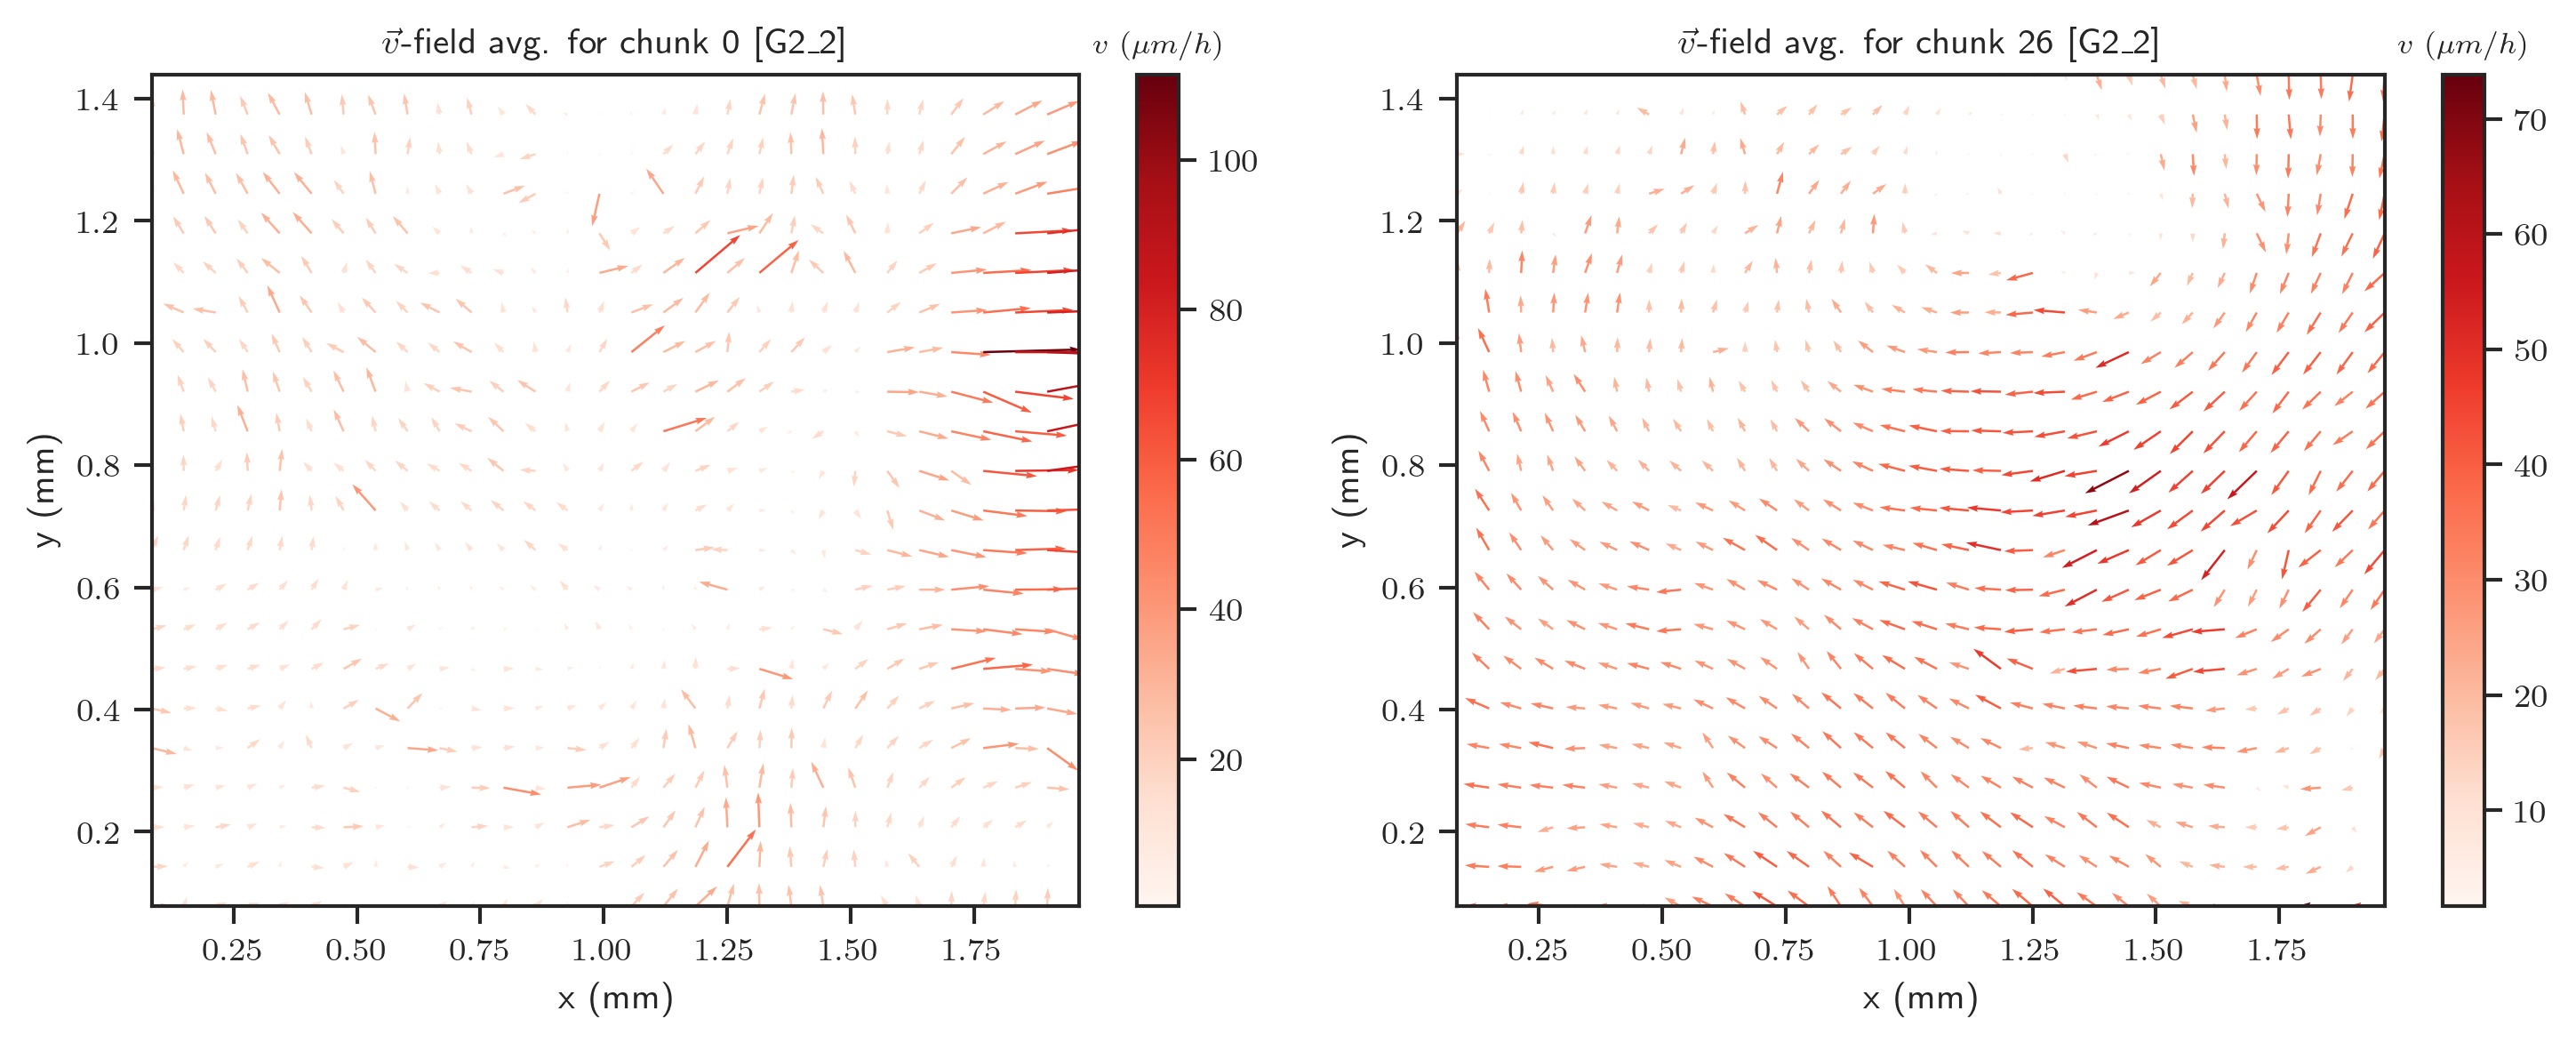

In [162]:
fov = 0

scale = 1e3  # µm/mm

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]

chunk = 0

ax, sp, cb = create_quiverplot(
    ax, x, y,
    u[fov, chunks[chunk]].mean(axis=0) * scale * 3600, 
    v[fov, chunks[chunk]].mean(axis=0) * scale * 3600,
    colorbar=True
)
cb.ax.set_title(r"$v\ (\mu m/h)$", fontsize=8)
ax.set(
    title=r"$\vec{v}$-field avg. for " + f"chunk {chunk} [{fovs[fov]}]",
    xlim=(x.min(), x.max()),
    ylim=(y.min(), y.max()),
    xlabel="x (mm)", ylabel="y (mm)"
)

ax = axes[1]
chunk = len(chunks) - 1
ax, sp, cb = create_quiverplot(
    ax, x, y,
    u[fov, chunks[chunk]].mean(axis=0) * scale * 3600, 
    v[fov, chunks[chunk]].mean(axis=0) * scale * 3600,
    colorbar=True
)
cb.ax.set_title(r"$v\ (\mu m/h)$", fontsize=8)
ax.set(
    title=r"$\vec{v}$-field avg. for " + f"chunk {chunk} [{fovs[fov]}]",
    xlim=(x.min(), x.max()),
    ylim=(y.min(), y.max()),
    xlabel="x (mm)", ylabel="y (mm)"
)
fig.tight_layout()
fig.savefig(plotpath / "example-velocity-field.png", bbox_inches="tight")

### plot multiple velocity maps?

In [163]:
if multiple_velocity_maps:
    fov = 0
    scale = 1e3  # µm/mm
    
    timelapsepath = plotpath / "velocity-timelapse"
    timelapsepath.mkdir(parents=True, exist_ok=True)

    abs_velocities_per_chunk = np.array([
        np.sqrt(
            (u[fov, chunk].mean(axis=0) * scale * 3600)**2 + \
            (v[fov, chunk].mean(axis=0) * scale * 3600)**2
        ) for chunk in chunks       
    ])
    
    for cnum in range(len(chunks)):
        chunk = cnum
    
        fig, ax = plt.subplots(figsize=(6, 4))
        ax, sp, cb = create_quiverplot(
            ax, x, y,
            u[fov, chunks[chunk]].mean(axis=0) * scale * 3600, 
            v[fov, chunks[chunk]].mean(axis=0) * scale * 3600,
            colorbar=True,
            vmin=np.nanmin(abs_velocities_per_chunk),
            vmax=np.nanmax(abs_velocities_per_chunk)
        )
        cb.ax.set_title(r"$v\ (\mu m/h)$", fontsize=8)
        ax.set(
            title=r"$\vec{v}$-field avg. for " + f"chunk {chunk} [{fovs[fov]}]",
            xlim=(x.min(), x.max()),
            ylim=(y.min(), y.max()),
            xlabel="x (mm)", ylabel="y (mm)"
        )
        fig.tight_layout()
        fig.savefig(timelapsepath / f"velocity-field-{cnum:02}.png", bbox_inches="tight")
        plt.close(fig)

## 3. Deriving quantities

### RMS velocities

In [164]:
total_vrms, total_vrms_std = rms_velocity(u, v, chunks)
vrms_star, vrms_star_std = rms_velocity(u_star, v_star, chunks)

scale = 1e3

age = np.array([(ch[0] + len(ch)/2) * config['piv']['dt'] / 3600 for ch in chunks])

(total_vrms*scale*3600).mean()=52.2, (vrms_star*scale*3600).mean()=46.4


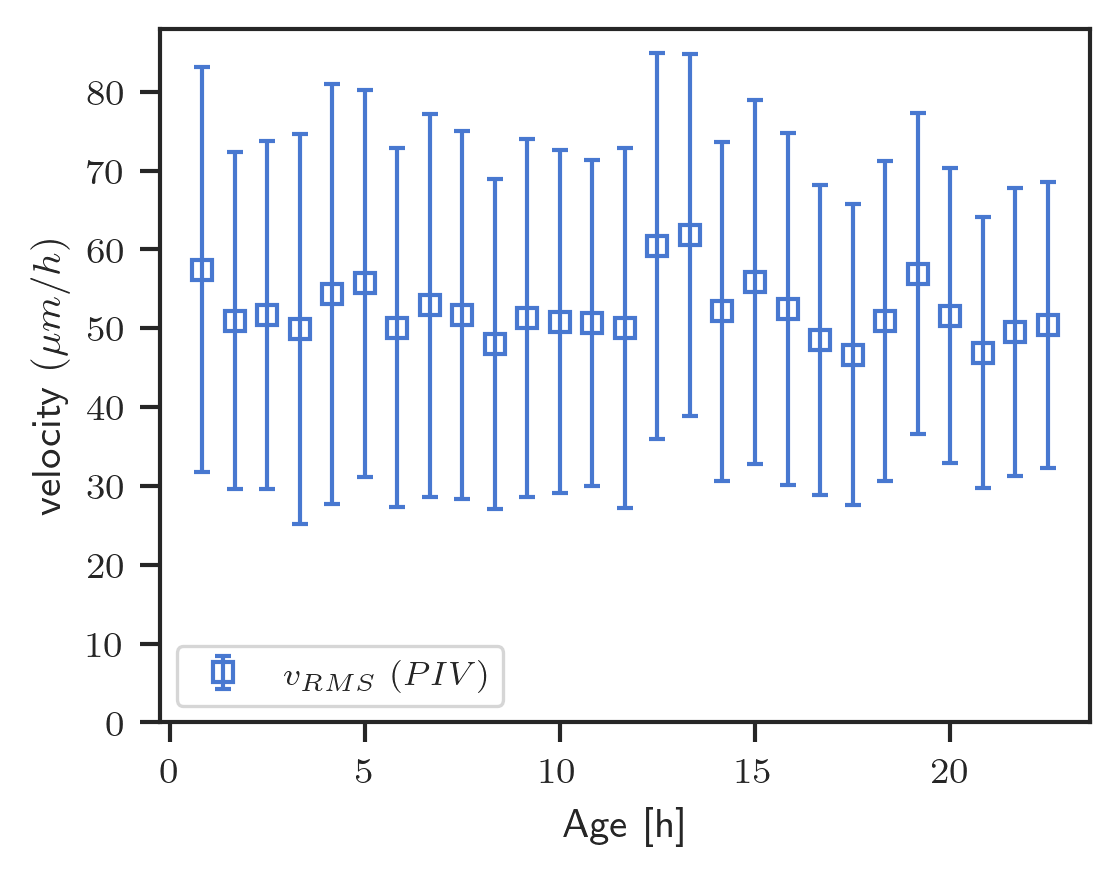

In [166]:
fig, ax = plt.subplots(figsize=(4, 3))
title = "total RMS velocity"
error_norm = np.sqrt([len(ch) for ch in chunks])

config = read_config(configpath, verbose=False)

# first total rms velocity
ax.errorbar(age, total_vrms*scale*3600, total_vrms_std*scale*3600/error_norm, label="$v_{RMS}\ (PIV) $",
            marker="s", markerfacecolor="None", lw=0, elinewidth=1, capsize=2)
# drift-corrected rms velocity
# ax.errorbar(age, vrms_star*scale, vrms_star_std*scale/error_norm, label="drift corrected $v^*_{RMS}$",
#             marker="o", markerfacecolor="None", lw=0, elinewidth=1, capsize=2)

ax.set_ylabel("velocity $(\mu m/h)$")
ax.set_xlabel("Age [h]")
ax.set_ylim(0, None)

# ax.set_title(title, fontsize=9)
ax.legend(fontsize=8)
print(f"{(total_vrms*scale*3600).mean()=:.3g}, {(vrms_star*scale*3600).mean()=:.3g}")

fig.savefig(plotpath / "velocity-comparison.png", bbox_inches="tight")

(total_vrms*scale*3600).mean()=52.2, (vrms_star*scale*3600).mean()=46.4


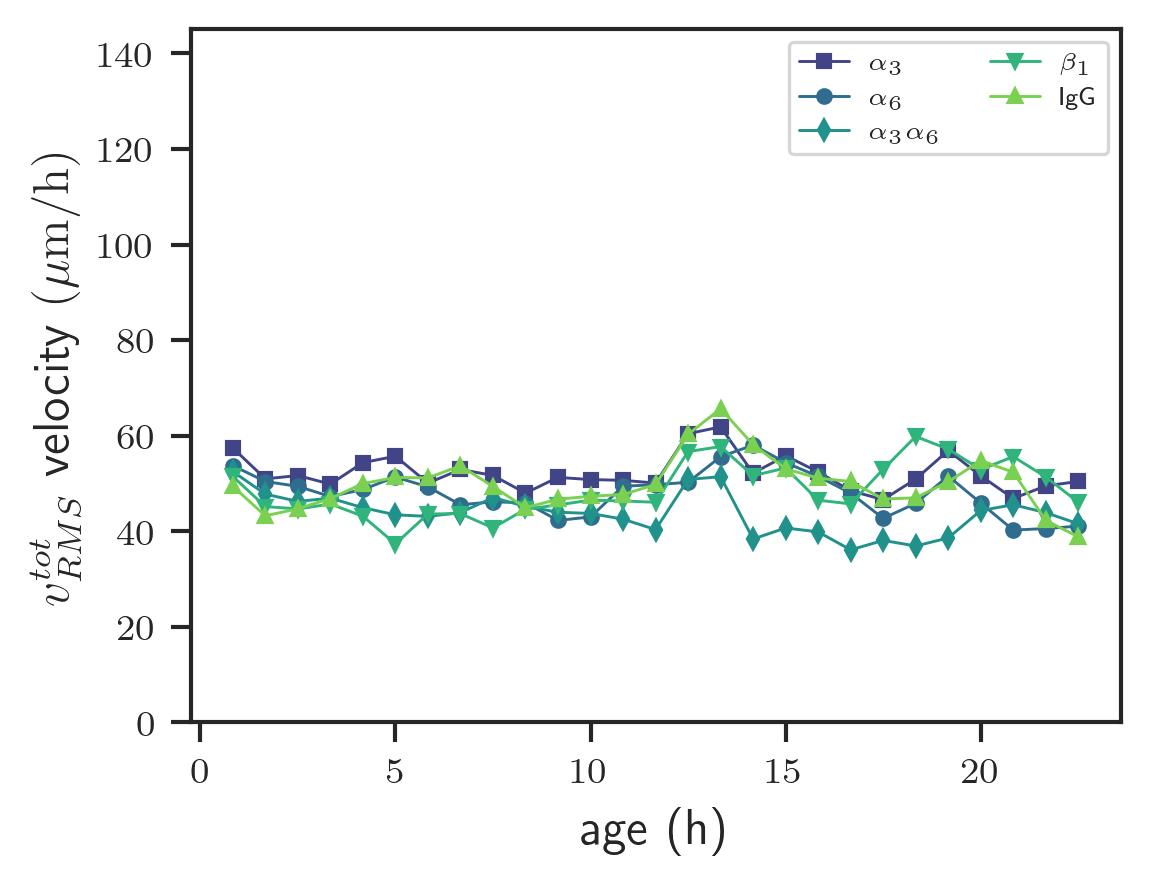

In [167]:
error_bars = False

if comparison_plots:
    comp_path = (Path("piv") / compare[0]).parent / "comparison"
    comp_path.mkdir(parents=True, exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(4, 3))
    title = "total RMS velocity"
    error_norm = np.sqrt([len(ch) for ch in chunks])
    
    config = read_config(configpath, verbose=False)

    comp_space = color_space(len(compare), vmin=0.2, vmax=0.8)
    symb_space = ["s", "o", "d", "v", "^"]
    
    # load, calculate and plot the RMS velocities
    for i, cpath in enumerate(compare):
        # filename
        cfile = Path("piv") / cpath / "data/piv-results.pkl"
        
        # load data
        cdata = pd.read_pickle(cfile)

        # compute total rms velocity
        comp_total_vrms, comp_total_vrms_std = rms_velocity(cdata["u"], cdata["v"], chunks)

        # plot the result
        ## set up the label
        label = cpath.split("/")[-1]
        for tm, desc in treatment_map.items():
            if label == tm:
                label = desc
        
        # first total rms velocity
        if error_bars:
            ax.errorbar(
                age,         
                comp_total_vrms*scale*3600, 
                comp_total_vrms_std*scale*3600/error_norm, 
                label=cpath,
                markersize=4, lw=0.7, elinewidth=0.7, capsize=1.5,
                color=comp_space[i], marker=symb_space[i],
            )
        if not error_bars:
            ax.plot(
                age,
                comp_total_vrms*scale*3600, 
                label=r"{}".format(label) ,
                markersize=3, lw=0.7,
                color=comp_space[i], marker=symb_space[i],
            )
        
    ax.set_ylabel("$v_{RMS}^{tot}$ velocity $(\mu \mathrm{m}/\mathrm{h})$", fontsize=12)
    ax.set_xlabel("age (h)", fontsize=12)
    ax.set_ylim(0, 145)
    ax.legend(fontsize=6, ncol=2)
    print(f"{(total_vrms*scale*3600).mean()=:.3g}, {(vrms_star*scale*3600).mean()=:.3g}")
    
    fig.savefig(comp_path / "total-velocity-comparison-scaled.pdf", format="pdf", bbox_inches="tight", dpi=300)

(total_vrms*scale*3600).mean()=52.2, (vrms_star*scale*3600).mean()=46.4


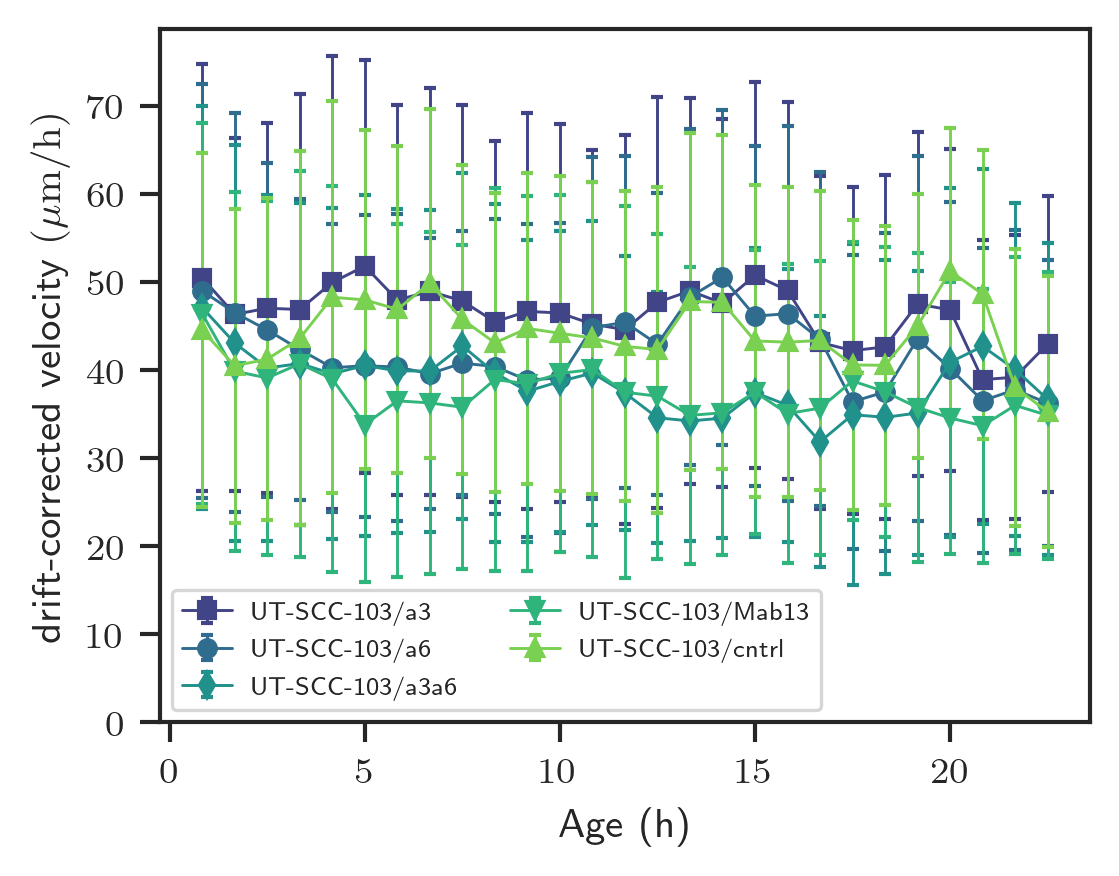

In [168]:
if comparison_plots:
    comp_path = (Path("piv") / compare[0]).parent / "comparison"
    comp_path.mkdir(parents=True, exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(4, 3))
    title = "total RMS velocity"
    error_norm = np.sqrt([len(ch) for ch in chunks])
    
    config = read_config(configpath, verbose=False)

    comp_space = color_space(len(compare), vmin=0.2, vmax=0.8)
    symb_space = ["s", "o", "d", "v", "^"]
    
    # load, calculate and plot the RMS velocities
    for i, cpath in enumerate(compare):
        # filename
        cfile = Path("piv") / cpath / "data/piv-results.pkl"

        # load data
        cdata = pd.read_pickle(cfile)

        # compute total rms velocity
        comp_total_vrms, comp_total_vrms_std = rms_velocity(cdata["u*"], cdata["v*"], chunks)

        # plot the result
    
        # first total rms velocity
        ax.errorbar(
            age,         
            comp_total_vrms*scale*3600, 
            comp_total_vrms_std*scale*3600/error_norm, 
            label=cpath,
            markersize=4, lw=0.7, elinewidth=0.7, capsize=1.5,
            color=comp_space[i], marker=symb_space[i],
        )
        
    ax.set_ylabel("drift-corrected velocity $(\mu \mathrm{m}/\mathrm{h})$")
    ax.set_xlabel("Age (h)")
    ax.set_ylim(0, None)
    ax.legend(fontsize=6, ncol=2)
    print(f"{(total_vrms*scale*3600).mean()=:.3g}, {(vrms_star*scale*3600).mean()=:.3g}")
    
    fig.savefig(comp_path / "drift-corrected-velocity-comparison.png", bbox_inches="tight", dpi=300)    

## 4. Correlation functions & correlation lengths

### Velocity-velocity radial correlation function $C_{vv}(\delta r, t)$

We want to compute the quantity:
$$
    C_{vv}(\delta \vec{r}, t) = \frac{\langle \vec{v}^*(\vec{r}+\delta \vec{r}, t) \cdot \vec{v}^*(\vec{r}, t)\rangle_\vec{r}}{\langle \vec{v}^*(\vec{r}, t)^2\rangle_\vec{r}}
$$

If we do not use the drift corrected velocity field, we *also* correlate the drift! So if we only want to correlate more the direction and not the drift, we have to use the drift corrected velocity field! For this see the supporting information of *Garcia et al. 10.1073/pnas.1510973112*, equ. (S18).

In [169]:
# we can use freud to do compute the correlation function
# see more details at https://freud.readthedocs.io/en/latest/gettingstarted/examples/module_intros/density.CorrelationFunction.html
import freud

`freud` can compute the correlation function $C(r) = \langle s_1^*(0)\cdot s_2(r)\rangle$ and do all the binning etc. for us.
In the link above they use a definitien of $s=\exp(i\theta)$; since we want to correlate velocities, we also want to add the amplitude of the velocity vector:
$$
    s=a\cdot \exp(i\theta),\ a=\sqrt{v_x^2 + v_y^2},\ \theta = \arctan\left( \frac{v_y}{v_x}\right)
$$

#### defining some helper functions

In [170]:
def complex_vel(u: np.ndarray, v: np.ndarray) -> np.ndarray:
    ampl = np.sqrt(u**2 + v**2)  # piece-wise
    angles = np.arctan2(v, u)  # note the arctan2
    return ampl * np.exp(angles * 1j)
    # return np.exp(angles * 1j)

def corr_func(
    points: np.ndarray, 
    u: np.ndarray, 
    v: np.ndarray,
    r_max: float,
    nbins: int = 25
) -> tuple[np.ndarray, np.ndarray]:

    # setup box
    box = freud.Box(*(points.max(axis=0) + points.min(axis=0)))
    cf = freud.density.CorrelationFunction(bins=nbins, r_max=r_max)

    # setup values
    norm = (u**2 + v**2).mean()
    values = complex_vel(u, v).T.flatten()

    # compute
    cf.compute(
        system=(box, points),
        values=values,
        query_points=points,
        query_values=values
    )

    return cf.bin_centers, cf.correlation.real/norm

#### setup

In [171]:
config = read_config(configpath, verbose=False)

nbins = config['piv-proc']['nbins'] if 'nbins' in config['piv-proc'].keys() else 30

# we still have to generate the points of the velocity vectors
from itertools import product
points = np.array(list(product(x[0], y[:, 0])))
points = np.vstack([*points.T, np.zeros(len(points))]).T

r_max = min(*points.max(axis=0)[:2])/2.01
# r_max = max(*points.max(axis=0))/2.6 # 2.7

### first compute correlation function on drift corrected velocity fields

In [172]:
cfs = np.zeros((len(u), len(u[0]), nbins))
for j in range(len(u)):
    print(f":: FOV {j:02d}")
    for i in range(len(u[j])):
        if i % 50 == 0:
            print(f"Step: {i}")
        bin_centers, ncf = corr_func(points, u_star[j, i], v_star[j, i], r_max, nbins=nbins)
        cfs[j, i] = ncf[:]

:: FOV 00
Step: 0
Step: 50
Step: 100


/tmp/ipykernel_154109/881354681.py:31: RuntimeWarning: invalid value encountered in divide
  return cf.bin_centers, cf.correlation.real/norm


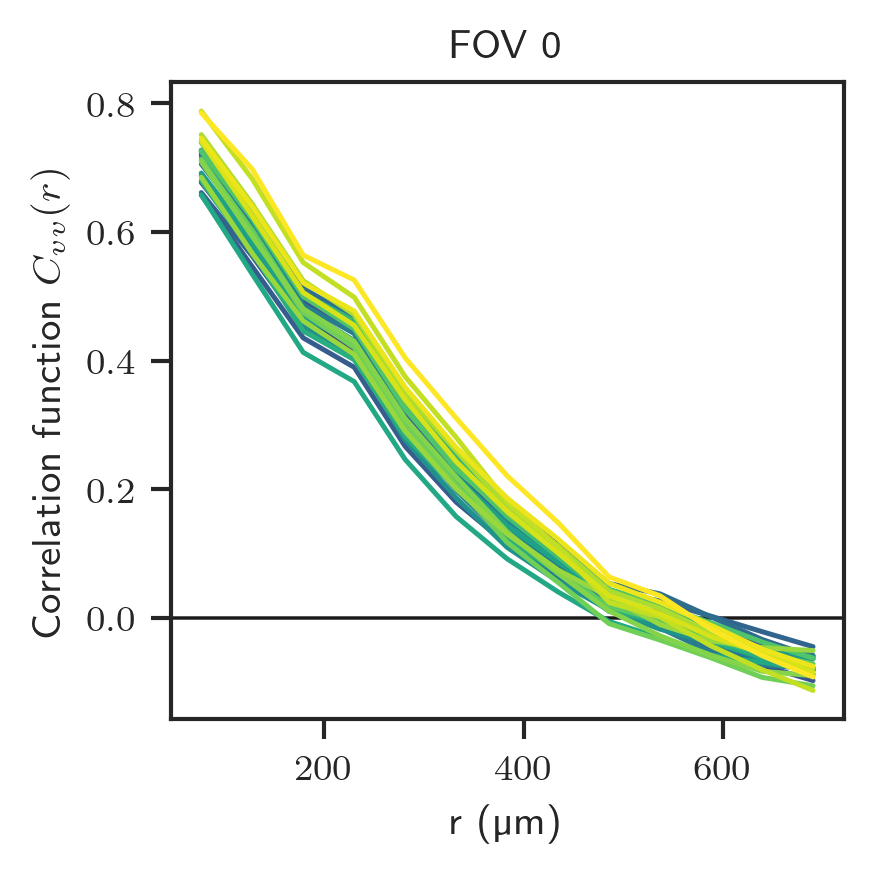

In [173]:
# cfs = np.array(cfs)
cspace = color_space(len(chunks))

fig, ax = plt.subplots(figsize=(3, 3), sharex=True, sharey=True)
i = 0
for j, ch in enumerate(chunks):
    ax.axhline(0, ls="-", color="k", lw=0.5, zorder=0)
    ax.plot(bin_centers[1:] * scale, np.nanmean(cfs[i][ch], axis=0)[1:], color=cspace[j])
# ax.set_ylim(1e-3, 1.1e0)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_title(f"FOV {i}")
ax.set_ylabel("Correlation function $C_{vv}(r)$")

ax.set_xlabel("r (µm)")
fig.tight_layout()
fig.savefig(plotpath / "vv-correlation-function-per-fov.png", bbox_inches="tight")

The fitting procedure below may find faulty values (i.e. `NaN` values). If the faulty values only occur in the last entry of the FOV, they can be ignored.

In [174]:
def exp(x, a, xi):
    return a * np.exp(-x/xi)

corr_mod = lm.Model(exp)
corr_mod.set_param_hint("xi", min=0, value=0.05)
corr_mod.set_param_hint("a", min=0, value=0.5, vary=True, max=3)

fit_results = np.zeros((*cfs.shape[:2], 2))

for j in range(len(cfs)):
    for i in range(len(cfs[j])):
        if not np.isnan(cfs[j, i]).any():
            # fit but exclude the first value
            res = corr_mod.fit(x=bin_centers[1:], data=cfs[j, i][1:])
            fit_results[j, i] = tuple(res.best_values.values())
        else:
            fit_results[j, i] = np.array([np.NaN, np.NaN])
            print(f"Found faulty values in FOV/entry {j}/{i}")

Found faulty values in FOV/entry 0/140


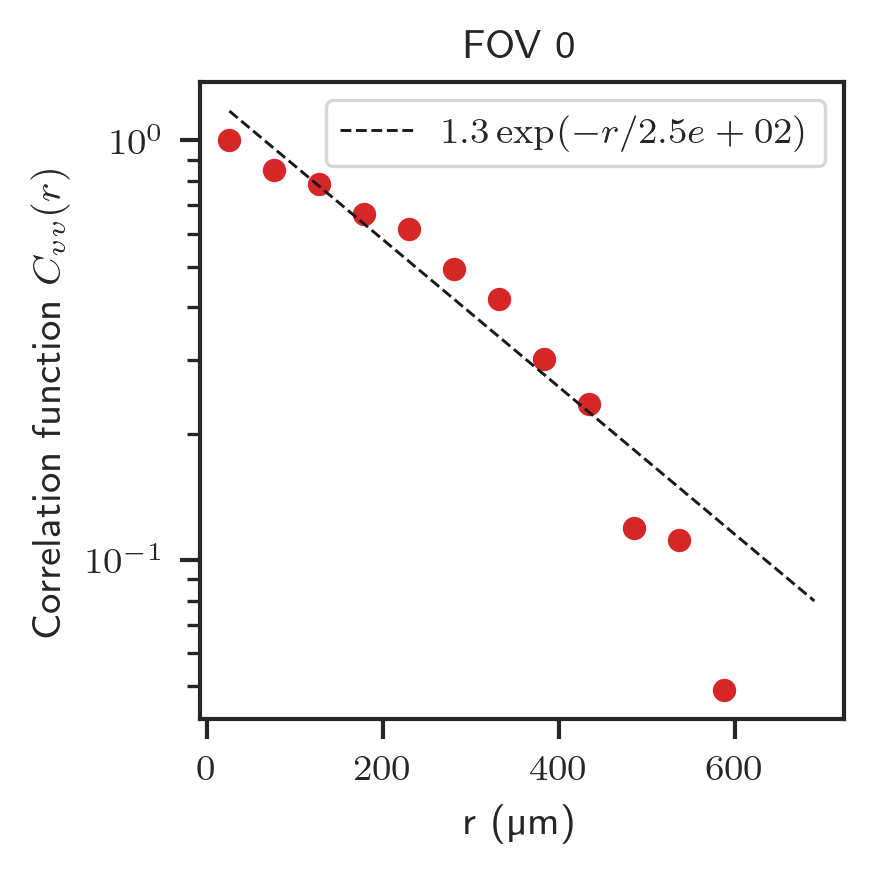

In [175]:
# cfs = np.array(cfs)
# cspace = color_space(len(chunks))

testframe = 10
test_range = np.linspace(bin_centers.min(), bin_centers.max())

fig, ax = plt.subplots(figsize=(3, 3), sharex=True, sharey=True)
i = 0

ax.scatter(bin_centers * scale, cfs[i, testframe], color="tab:red")
ax.plot(test_range * scale, exp(test_range, *fit_results[i, testframe]), 
        color="k", ls="--", lw=0.7, label=r"${:.1f}\exp(-r/{:.2g})$".format(*(fit_results[i, testframe] * np.array([1, scale]))))

# ax.set_ylim(1e-5, 1.1e0)
ax.set_yscale('log')
# ax.set_ylim(1e-4, 1.1)
ax.legend()
# ax.set_xscale('log')
ax.set_title(f"FOV {i}")

ax.set_ylabel("Correlation function $C_{vv}(r)$")
ax.set_xlabel("r (µm)")
fig.tight_layout()
fig.savefig(plotpath / "example-vv-correlation-function-frame.png", bbox_inches="tight")

Below we construct two pandas DataFrames that contain the correlation length and amplitude. The first DataFrame contains the results for each frame and FOV, the second one is averaged over FOVs _and_ over chunks.

In [176]:
ampl, corrlen = fit_results.transpose((2, 0, 1))

# per frame
corr_results = pd.DataFrame(columns=["correlation length", "amplitude", "frame", "fov"])
for i, fov in enumerate(images):
    corr_results = pd.concat([
        corr_results,
        pd.DataFrame(data={
            "correlation length": corrlen[i] * scale,  # in µm
            "amplitude": ampl[i],
            "frame": np.arange(len(corrlen[i])) * config['piv-proc']['use_every'],
            "fov": [i+1] * len(corrlen[i])
        })],
        ignore_index=True
    )

# per chunk
corr_results_chunks = pd.DataFrame(columns=["correlation length", "amplitude", "fov", "chunk", "age"])

for ifov in range(len(images)):
    for cnum, chunk in enumerate(chunks):
        corr_results_chunks = pd.concat([
            corr_results_chunks,
            pd.DataFrame(data={
                "correlation length": [np.nanmean(corrlen[ifov][chunk])*scale],
                "amplitude": [np.nanmean(ampl[ifov][chunk])],
                "fov": [ifov+1],
                "chunk": [cnum],
                "age": [age[cnum]]
            })
        ], ignore_index=True)

/tmp/ipykernel_154109/847582106.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_results = pd.concat([
/tmp/ipykernel_154109/847582106.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_results_chunks = pd.concat([


<Axes: xlabel='age', ylabel='correlation length'>

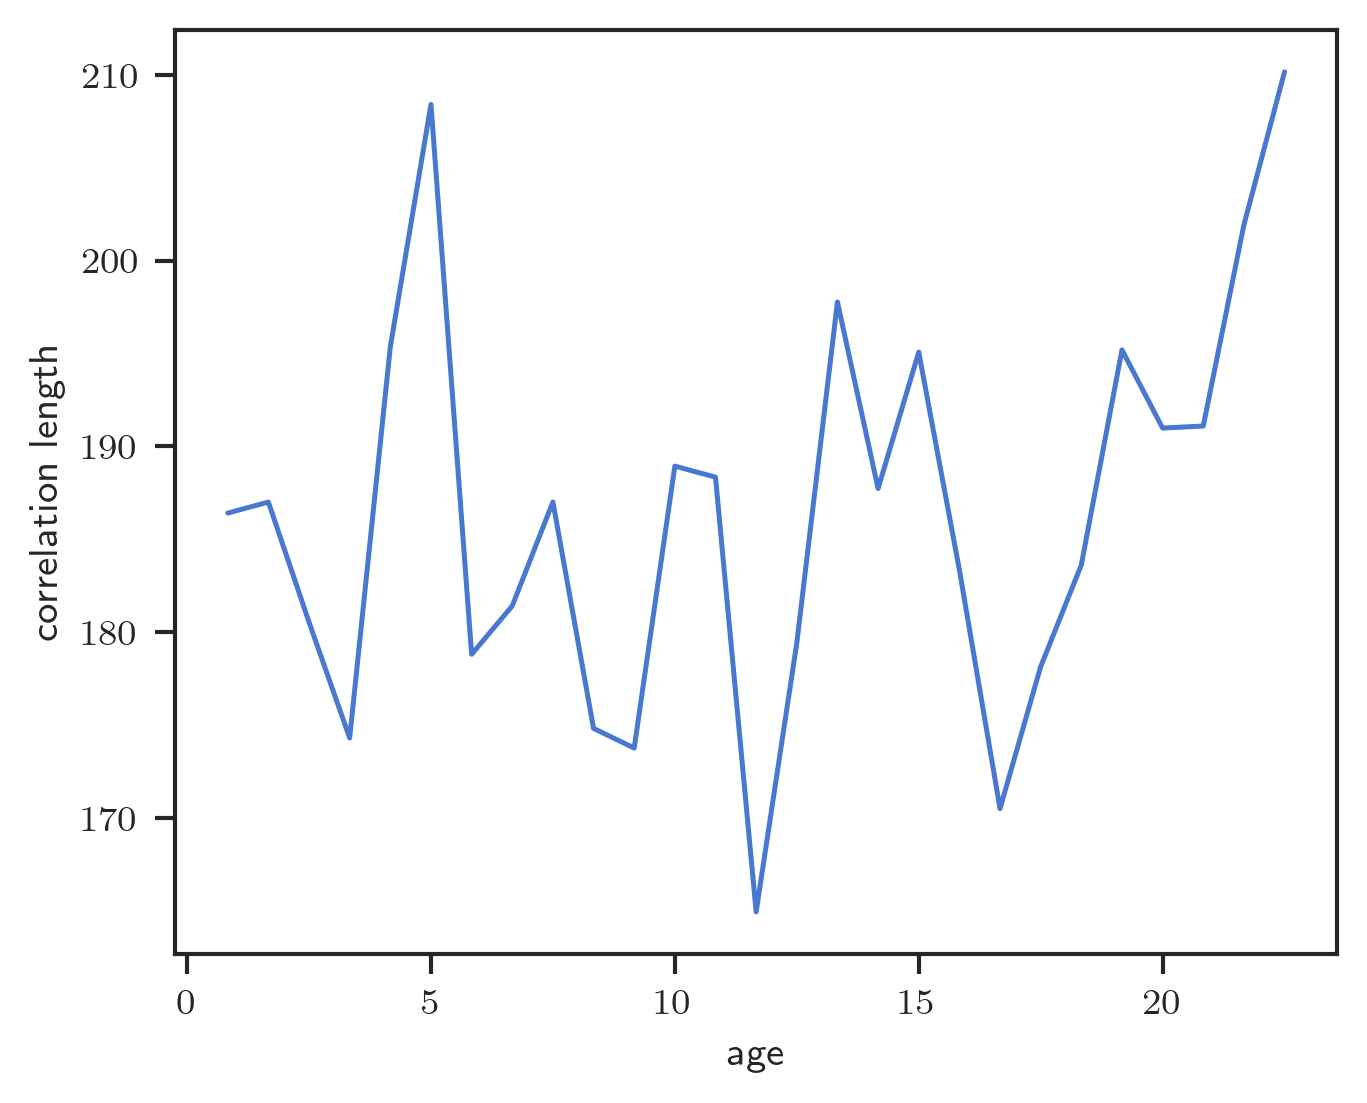

In [177]:
plt.figure(figsize=(5, 4))
sns.lineplot(data=corr_results_chunks, x="age", y="correlation length", errorbar="sd") 

Plot the correlation length with error bars.

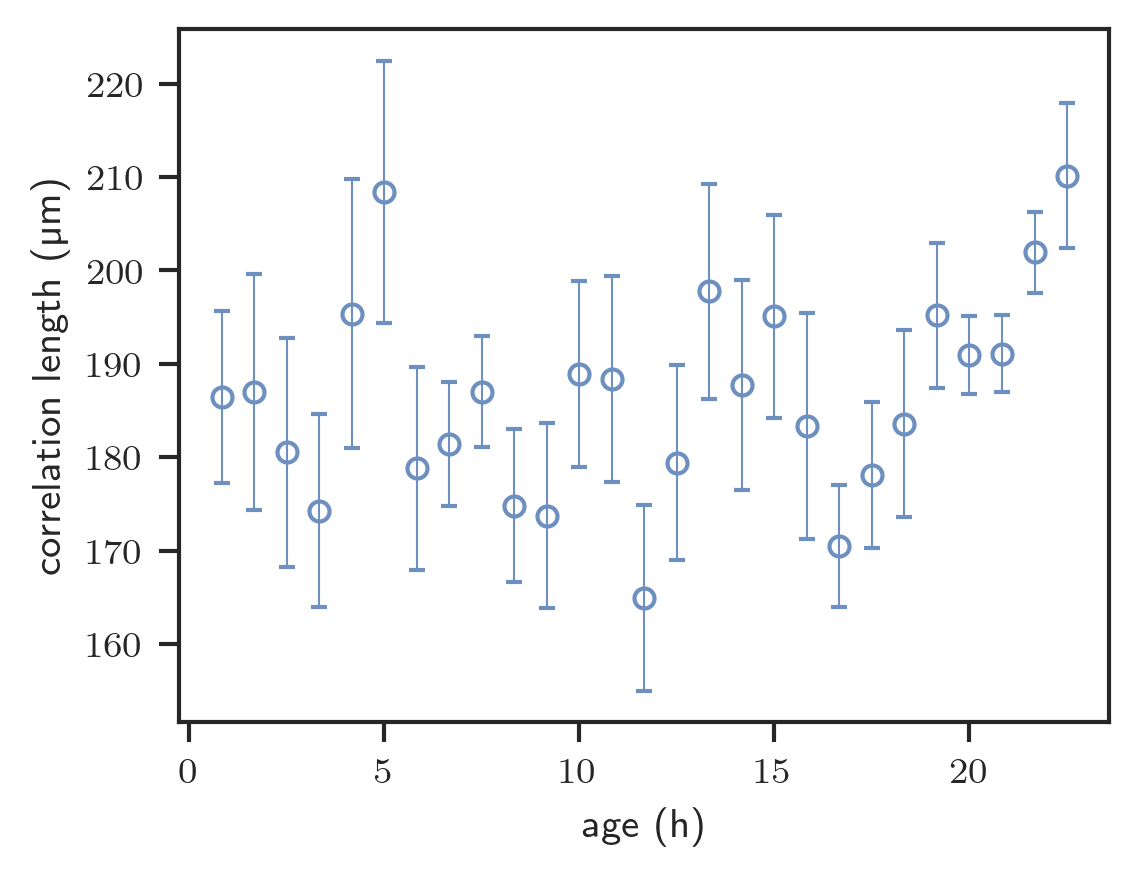

In [178]:
qualitative_cspace = color_space(len(corrlen), plt.cm.twilight)

plt.figure(figsize=(4, 3))
for i in range(len(corrlen)):
    plt.errorbar(
        age, 
        np.array([np.nanmean(corrlen[i][chunk]) for chunk in chunks])*scale, 
        yerr=np.array([np.nanstd(corrlen[i][chunk])/np.sqrt(len(chunk)) for chunk in chunks])*scale,
        label=f"FOV {i}", 
        color=qualitative_cspace[i],
        capsize=2, marker="o", lw=0, elinewidth=0.5, markerfacecolor="None")
# plt.plot(age, np.array([corrlen[:, chunk].mean(axis=1) for chunk in chunks]).mean(axis=1)*scale, ls="--", lw=2, color="tab:red", label="FOV mean")

# plt.legend(fontsize=8)
plt.ylabel("correlation length (µm)")
plt.xlabel("age (h)")
plt.savefig(plotpath / "correlation-length-chunk-fov.png", bbox_inches="tight")

Text(0.5, 0, 'age (h)')

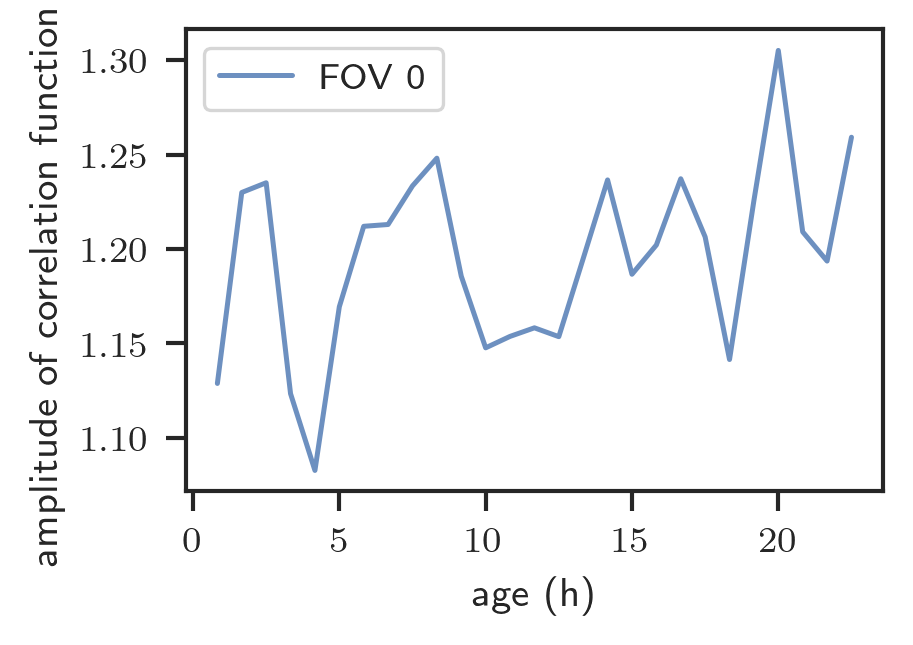

In [179]:
qualitative_cspace = color_space(len(corrlen), plt.cm.twilight)

plt.figure(figsize=(3, 2))

for i in range(len(ampl)):
    plt.plot(age, [ampl[i][chunk].mean() for chunk in chunks], label=f"FOV {i}", 
             color=qualitative_cspace[i])

plt.legend()
plt.ylabel("amplitude of correlation function fit")
plt.xlabel("age (h)")
# plt.savefig(plotpath / "correlation-amplitude-fov-chunk.png", dpi=150)

### then compute the correlation function on the non-drift corrected velocity fields

In [180]:
cfs_ndc = np.zeros((len(u), len(u[0]), nbins))
for j in range(len(u)):
    print(f":: FOV {j:02d}")
    for i in range(len(u[j])):
        if i % 50 == 0:
            print(f"Step: {i}")
        bin_centers, ncf = corr_func(points, u[j, i], v[j, i], r_max, nbins=nbins)
        cfs_ndc[j, i] = ncf[:]

:: FOV 00
Step: 0
Step: 50
Step: 100


/tmp/ipykernel_154109/881354681.py:31: RuntimeWarning: invalid value encountered in divide
  return cf.bin_centers, cf.correlation.real/norm


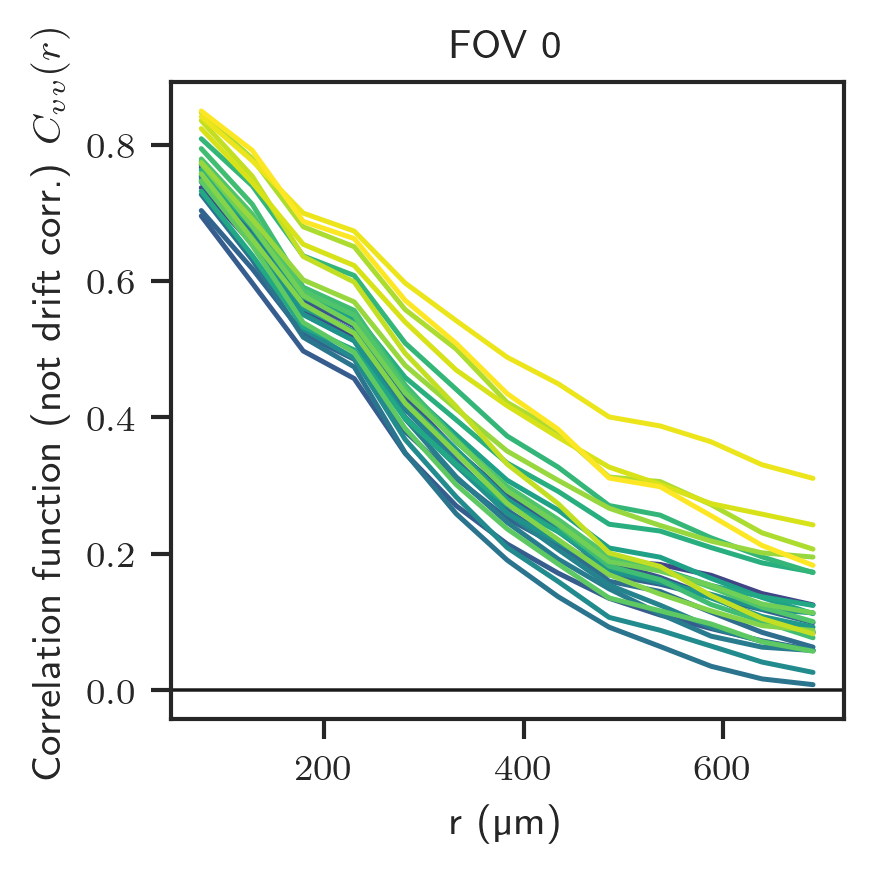

In [181]:
# cfs = np.array(cfs)
cspace = color_space(len(chunks))

fig, ax = plt.subplots(figsize=(3, 3), sharex=True, sharey=True)
i = 0
for j, ch in enumerate(chunks):
    ax.axhline(0, ls="-", color="k", lw=0.5, zorder=0)
    ax.plot(bin_centers[1:] * scale, np.nanmean(cfs_ndc[i][ch], axis=0)[1:], color=cspace[j])

ax.set_title(f"FOV {i}")
ax.set_ylabel("Correlation function (not drift corr.) $C_{vv}(r)$")

ax.set_xlabel("r (µm)")
fig.tight_layout()
fig.savefig(plotpath / "vv-correlation-function-ndc-per-fov.png", bbox_inches="tight")

In [182]:
fit_results_ndc = np.zeros((*cfs_ndc.shape[:2], 2))

for j in range(len(cfs_ndc)):
    for i in range(len(cfs_ndc[j])):
        if not np.isnan(cfs_ndc[j, i]).any():
            # fit but exclude the first value
            res = corr_mod.fit(x=bin_centers[1:], data=cfs_ndc[j, i][1:])
            fit_results_ndc[j, i] = tuple(res.best_values.values())
        else:
            fit_results_ndc[j, i] = np.array([np.NaN, np.NaN])
            print(f"Found faulty values in FOV/entry {j}/{i}")

Found faulty values in FOV/entry 0/140


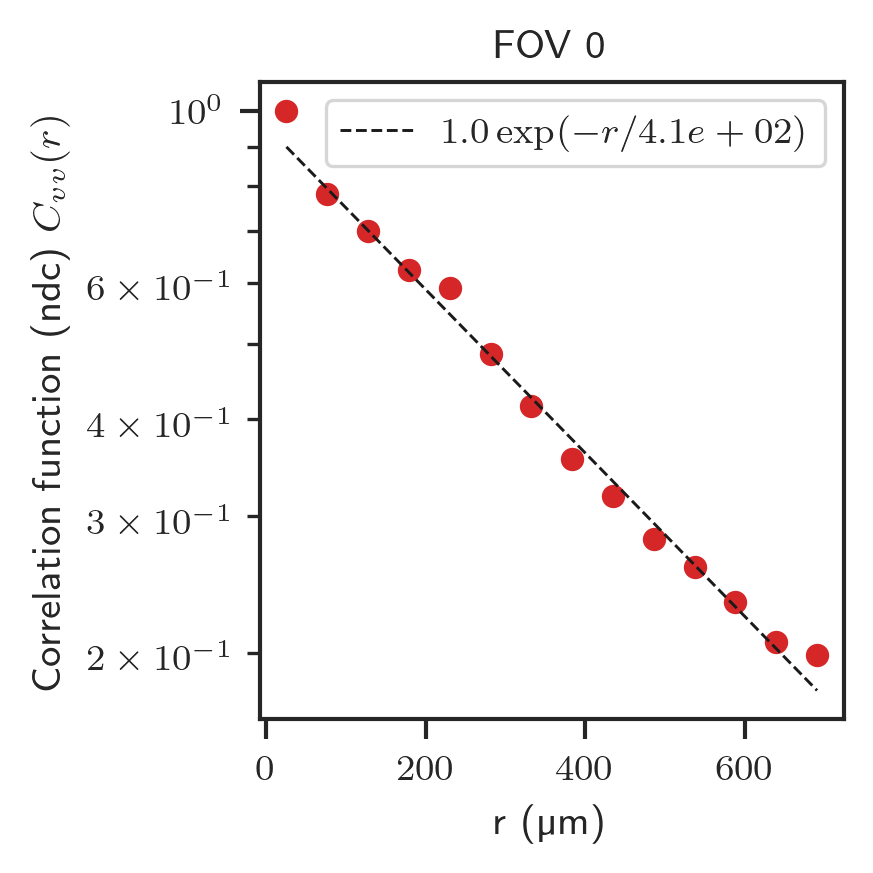

In [183]:
testframe = 20
test_range = np.linspace(bin_centers.min(), bin_centers.max())

fig, ax = plt.subplots(figsize=(3, 3), sharex=True, sharey=True)
i = 0

ax.scatter(bin_centers * scale, cfs_ndc[i, testframe], color="tab:red")
ax.plot(test_range * scale, exp(test_range, *fit_results_ndc[i, testframe]), 
        color="k", ls="--", lw=0.7, label=r"${:.1f}\exp(-r/{:.2g})$".format(*(fit_results_ndc[i, testframe] * np.array([1, scale]))))

ax.set_yscale('log')
ax.legend()
ax.set_title(f"FOV {i}")

ax.set_ylabel("Correlation function (ndc) $C_{vv}(r)$")
ax.set_xlabel("r (µm)")
fig.tight_layout()
fig.savefig(plotpath / "example-vv-correlation-function-ndc-frame.png", bbox_inches="tight")

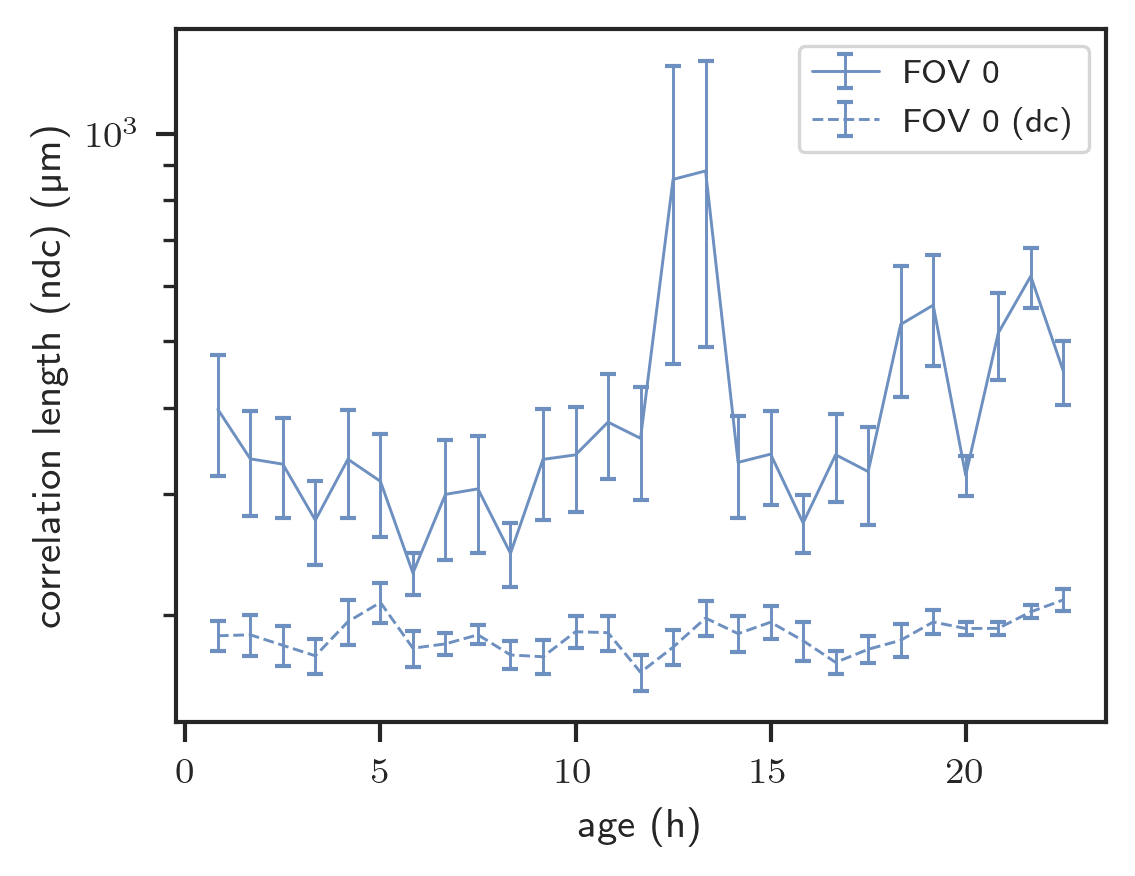

In [184]:
ampl_ndc, corrlen_ndc = fit_results_ndc.transpose((2, 0, 1))

qualitative_cspace = color_space(len(corrlen), plt.cm.twilight)

plt.figure(figsize=(4, 3))
for i in range(len(corrlen)):
    plt.errorbar(
        age, 
        np.array([np.nanmean(corrlen_ndc[i][chunk]) for chunk in chunks])*scale, 
        yerr=np.array([np.nanstd(corrlen_ndc[i][chunk])/np.sqrt(len(chunk)) for chunk in chunks])*scale,
        label=f"FOV {i}", 
        color=qualitative_cspace[i],
        capsize=2, lw=0.7)
    plt.errorbar(
        age, 
        np.array([np.nanmean(corrlen[i][chunk]) for chunk in chunks])*scale, 
        yerr=np.array([np.nanstd(corrlen[i][chunk])/np.sqrt(len(chunk)) for chunk in chunks])*scale,
        label=f"FOV {i} (dc)", 
        color=qualitative_cspace[i],
        capsize=2, lw=0.7, ls="--")
# plt.plot(age, np.array([corrlen[:, chunk].mean(axis=1) for chunk in chunks]).mean(axis=1)*scale, ls="--", lw=2, color="tab:red", label="FOV mean")

plt.yscale('log')
plt.legend(fontsize=8)
plt.ylabel("correlation length (ndc) (µm)")
plt.xlabel("age (h)")
plt.savefig(plotpath / "correlation-length-ndc-chunk-fov.png", bbox_inches="tight")


### Continue with correlation length vs RMS velocity

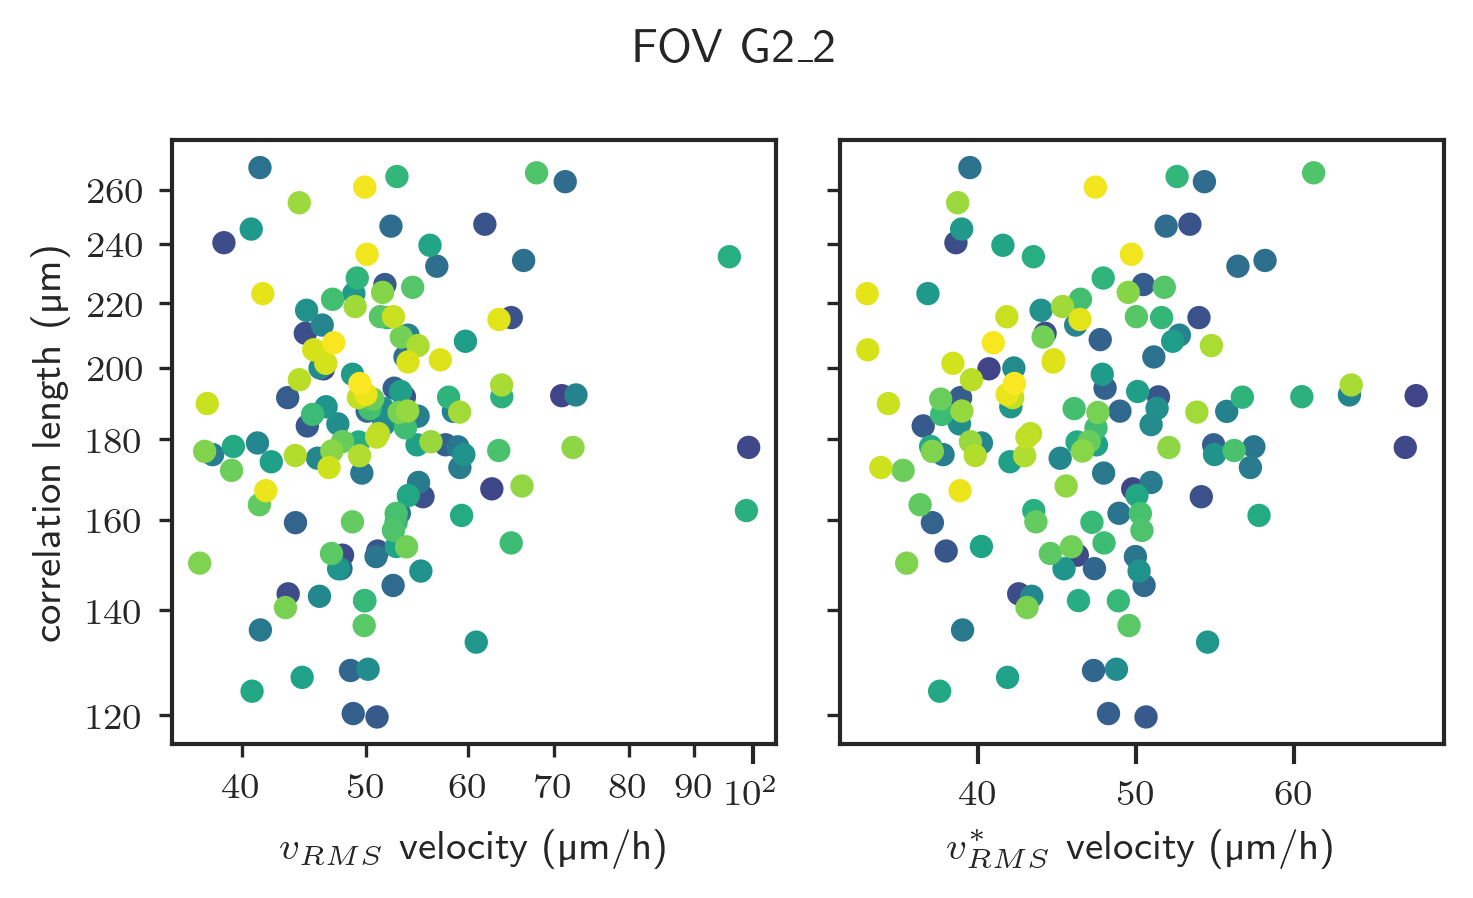

In [185]:
import matplotlib.ticker as mticker

fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharey=True)

# vs rms velocity
ax = axes[0]
ax.scatter(
    np.sqrt((u[i]**2 + v[i]**2).mean(axis=(-1, -2)))*scale*3600, corrlen[i]*scale,
    c=color_space(len(corrlen[i]))
)
# ax.set_ylim(0, 50)
ax.set_xlabel("$v_{RMS}$ velocity (µm/h)")
ax.set_ylabel("correlation length (µm)")

ax.set(
    xscale='log',
    yscale='log'
)
ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
# ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

# vs. drift corrected rms velocity
ax = axes[1]
ax.scatter(
    np.sqrt((u_star[i]**2 + v_star[i]**2).mean(axis=(-1, -2)))*scale*3600, corrlen[i]*scale,
    c=color_space(len(corrlen[i]))
)
ax.set_xlabel("$v^*_{RMS}$ velocity (µm/h)")

fig.suptitle(f"FOV {fovs[i]}")
fig.tight_layout()
fig.savefig(plotpath / "correlation-length-RMS-scatter.png", bbox_inches="tight")

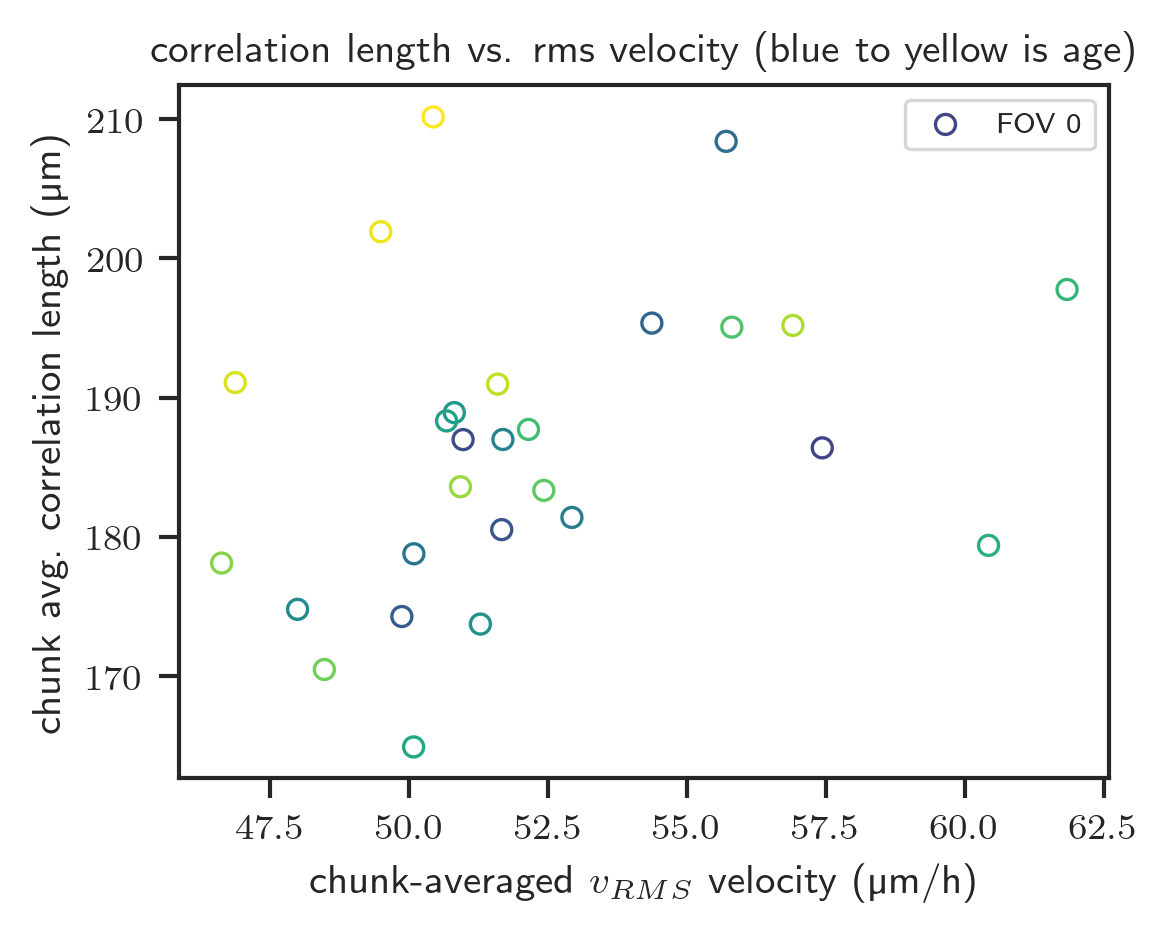

In [186]:
fig, ax = plt.subplots(figsize=(4, 3))
symbols = ["o", "s", "d", "v", "^", "*", "8", "P", "p", "h"]
for i in range(len(cfs)):
    ax.scatter(
        [np.sqrt((u[i]**2 + v[i]**2).mean(axis=(-1, -2)))[chunk].mean()*scale*3600 for chunk in chunks], 
        [corrlen[i][chunk].mean()*scale for chunk in chunks],
        edgecolor=color_space(len(chunks)), label=f"FOV {i}", marker=symbols[i], facecolor="None")

ax.legend(fontsize=7, ncol=2)
# plt.xscale('log')
# plt.yscale('log')
ax.set_xlabel("chunk-averaged $v_{RMS}$ velocity (µm/h)")
ax.set_ylabel("chunk avg. correlation length (µm)")
ax.set_title("correlation length vs. rms velocity (blue to yellow is age)", fontsize=10)
fig.savefig(plotpath / "correlation-length-RMS-avg-fov.png", bbox_inches="tight")

Building a dataframe that contains the correlation length and RMS velocities based on FOV and chunk.

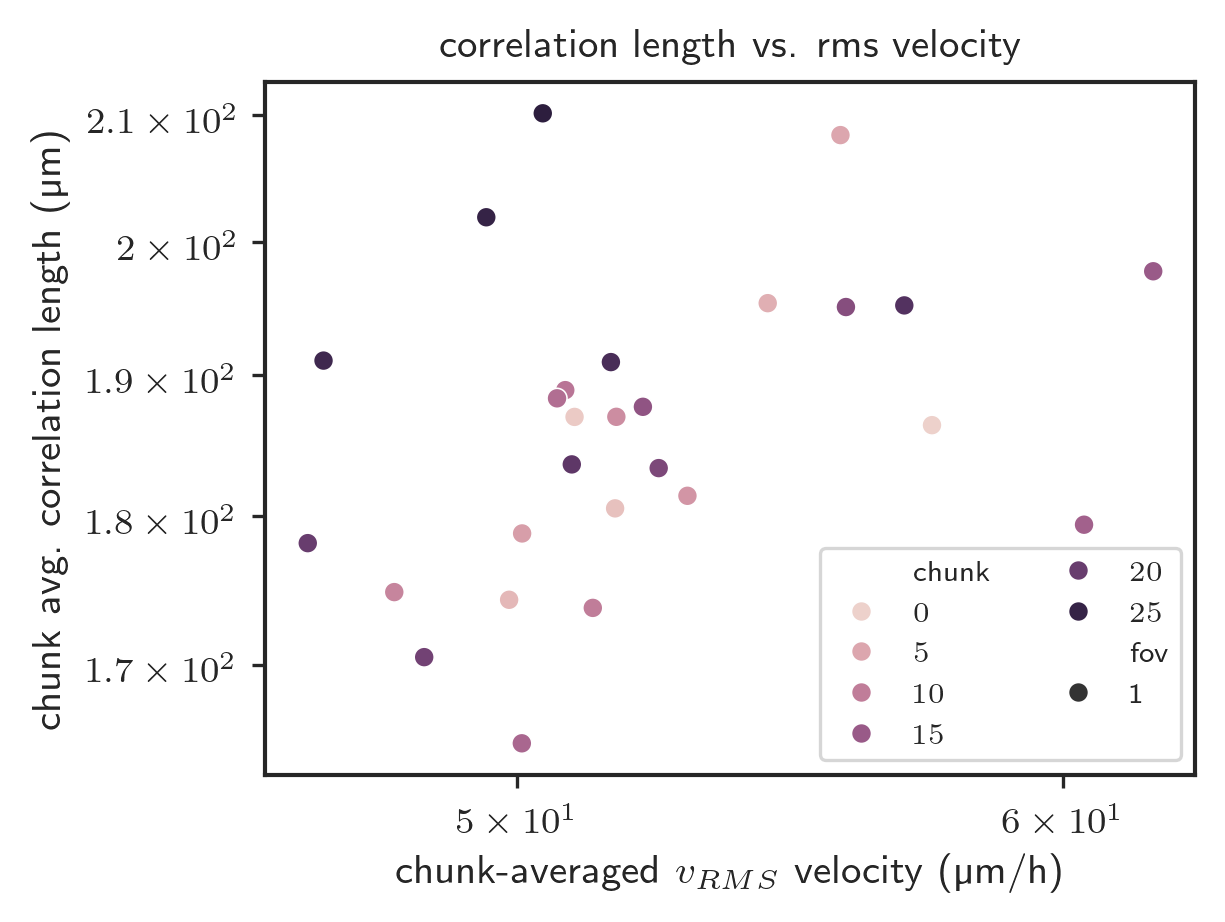

In [187]:
corr_results_RMS_chunk = pd.DataFrame()
for i, fov in enumerate(images):
    corr_results_RMS_chunk = pd.concat([
        corr_results_RMS_chunk, 
        pd.DataFrame(data={
            "correlation length": [corrlen[i][chunk].mean()*scale for chunk in chunks],
            "RMS": total_vrms * scale * 3600,  # in µm/h
            "RMS*": vrms_star * scale * 3600, # in µm/h
            "fov": [i+1] * len(chunks),
            "chunk": np.arange(len(chunks))
        })], ignore_index=True
    )

# save results
corr_results_RMS_chunk.to_pickle(datapath / "correlation-results.pkl")

fig, ax = plt.subplots(figsize=(4, 3))

sp = sns.scatterplot(
    data=corr_results_RMS_chunk, 
    x="RMS", 
    y="correlation length", 
    hue="chunk", 
    style="fov",
    ax=ax
)
ax.legend(ncol=2, fontsize=7)
ax.set(
    xlabel="chunk-averaged $v_{RMS}$ velocity (µm/h)",
    ylabel="chunk avg. correlation length (µm)",
    title="correlation length vs. rms velocity",
    xscale='log',
    yscale='log'
)
fig.savefig(plotpath / "correlation-length-RMS-avg-fov-fancy.png", bbox_inches="tight")

**Big comparison plot** of different treatments and correlation length vs RMS velocity.

In [188]:
## the plots below need this conversion function to produce rgb tuples from hex codes

def convert_hex_to_rgb(h: str) -> tuple[int, int, int]:
    """Convert a hex color string to RGB."""
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))



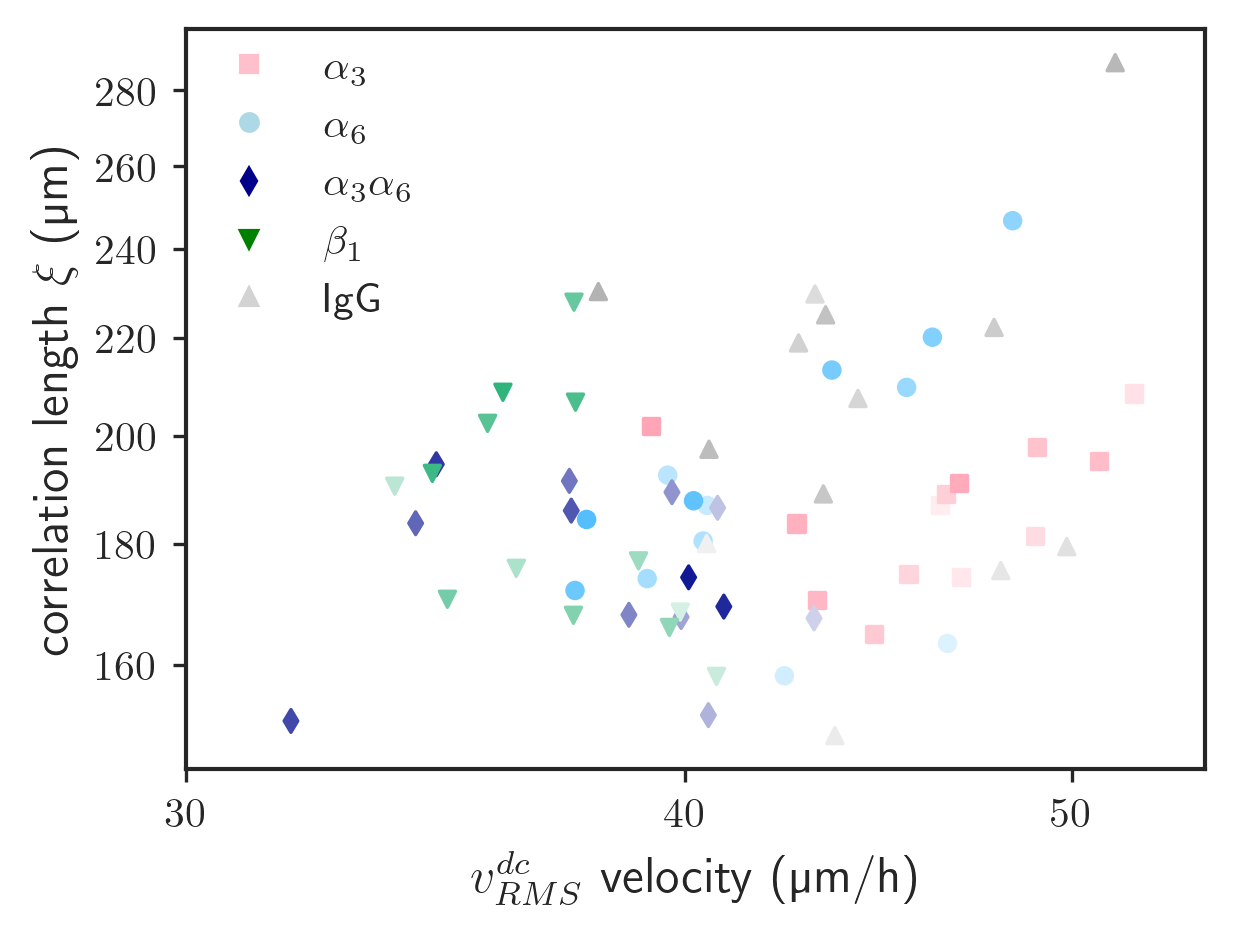

In [189]:
if comparison_plots:
    from matplotlib.ticker import ScalarFormatter
    from matplotlib.lines import Line2D
    from matplotlib.colors import LinearSegmentedColormap
    
    comp_path = (Path("piv") / compare[0]).parent / "comparison"
    comp_path.mkdir(parents=True, exist_ok=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), layout="constrained")
    # title = "correlation length vs. RMS velocity"
    # error_norm = np.sqrt([len(ch) for ch in chunks])
    
    config = read_config(configpath, verbose=False)

    comp_space = color_space(len(compare), vmin=0.2, vmax=0.8)
    symb_space = ["s", "o", "d", "v", "^"]
    
    # empty DataFrame for collecting results
    comp_corr_df = pd.DataFrame()
    
    # load, calculate and plot the RMS velocities
    for i, cpath in enumerate(compare):
        # filename
        cfile = Path("piv") / cpath / "data/correlation-results.pkl"

        # load data
        cdata = pd.read_pickle(cfile)
        label = cpath.split("/")[-1]
        cdata["data_raw"] = [label] * len(cdata)
        for tm, desc in treatment_map.items():
            if label == tm:
                label = desc
        cdata["data"] = [label] * len(cdata)
        cdata["age"] = age

        # stack with collection df
        comp_corr_df = pd.concat([comp_corr_df, cdata], ignore_index=True)

    
    # plot the result
    ## FILTER THE RESULTS HERE ####
    
    filter_list = list(comp_corr_df["age"].unique()[::2])  

    ###############################

    ## Color Map names here #######
    
    color_names = ["pink", "lightblue", "darkblue", "green", "lightgrey"]
    hex_codes = ["ffa5b6ff", "55bffdff", "101a95ff", "2fb47cff", "b3b3b3ff"]

    
    #old #color_names = ["darkblue", "steelblue", "lightseagreen", "turquoise", "limegreen"]
    cmaps = {
        k: v for k, v in zip(
            list(comp_corr_df["data_raw"].unique()),
            [LinearSegmentedColormap.from_list(name, ["white", convert_hex_to_rgb(col)]) for name, col in zip(color_names, hex_codes)]
        )
    }
    
    for i, kind in enumerate(list(comp_corr_df["data_raw"].unique())):
        df = comp_corr_df.query(f"data_raw == '{kind}'").query(f"age not in {filter_list}")
        # print(i, kind)
        sc = ax.scatter(
            df["RMS*"],
            df["correlation length"],
            c=color_space(len(df["age"]), colormap=cmaps[kind], vmin=0.2),
            marker=symb_space[i],
            s=15,
            #cmap=cmaps[kind], # cmap_names[i],
            label=df["data"].unique()[0],
        )
        
         
    # color bar
    norm = plt.Normalize(0, 24)
    sm = plt.cm.ScalarMappable(cmap=sns.color_palette("flare", as_cmap=True), norm=norm)
    sm.set_array([])
    # plt.colorbar(sm, ax=ax, label=r"age ($\mathrm{h}$)")

    # legend
    
    custom_legend_handles = [
        Line2D([0], [0], color=col, lw=0, marker=m, markersize=4) for m, col in zip(symb_space, color_names)
    ]

    ax.legend(
        custom_legend_handles, 
        comp_corr_df["data"].unique(),
        fontsize=10, ncol=1, loc=0,
        frameon=False,
        borderpad=0
    )

    xlim = (None, None)
    # cosmetics
    if "HaCaT" in str(comp_path):
        dataset_label = "HaCaT"
        xlim = (10, None)

    elif "UT-SCC-103" in str(comp_path):
        dataset_label = "UT-SCC-103"
        xlim = (30, 54)

    elif "UT-SCC-11" in str(comp_path):
        dataset_label = "UT-SCC-11"
        ax.set_ylim(None, 400)

    ax.set(
        xlim=xlim,
        xscale='log',
        yscale='log'
    )
    ax.set_xlabel(r"$v^{dc}_{RMS}$ velocity (µm/h)", fontsize=12)
    ax.set_ylabel(r"correlation length $\xi$ (µm)", fontsize=12)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=10)

    output_dir = Path(".") / "new_figures" / dataset_label
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # ax.legend()
    fig.savefig(output_dir / f"corr_length_rms_comparison_{dataset_label}_50%.pdf", format="pdf", bbox_inches="tight", dpi=300)


    #save csv file with label
    csv_name = f"corr_length_rms_comparison_{dataset_label}_50%.csv"
    comp_corr_df.to_csv(output_dir / csv_name, index=False) #save raw data in csv file

Plot correlation length per treatment as a function of age.

/tmp/ipykernel_154109/4048811759.py:5: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.lineplot(


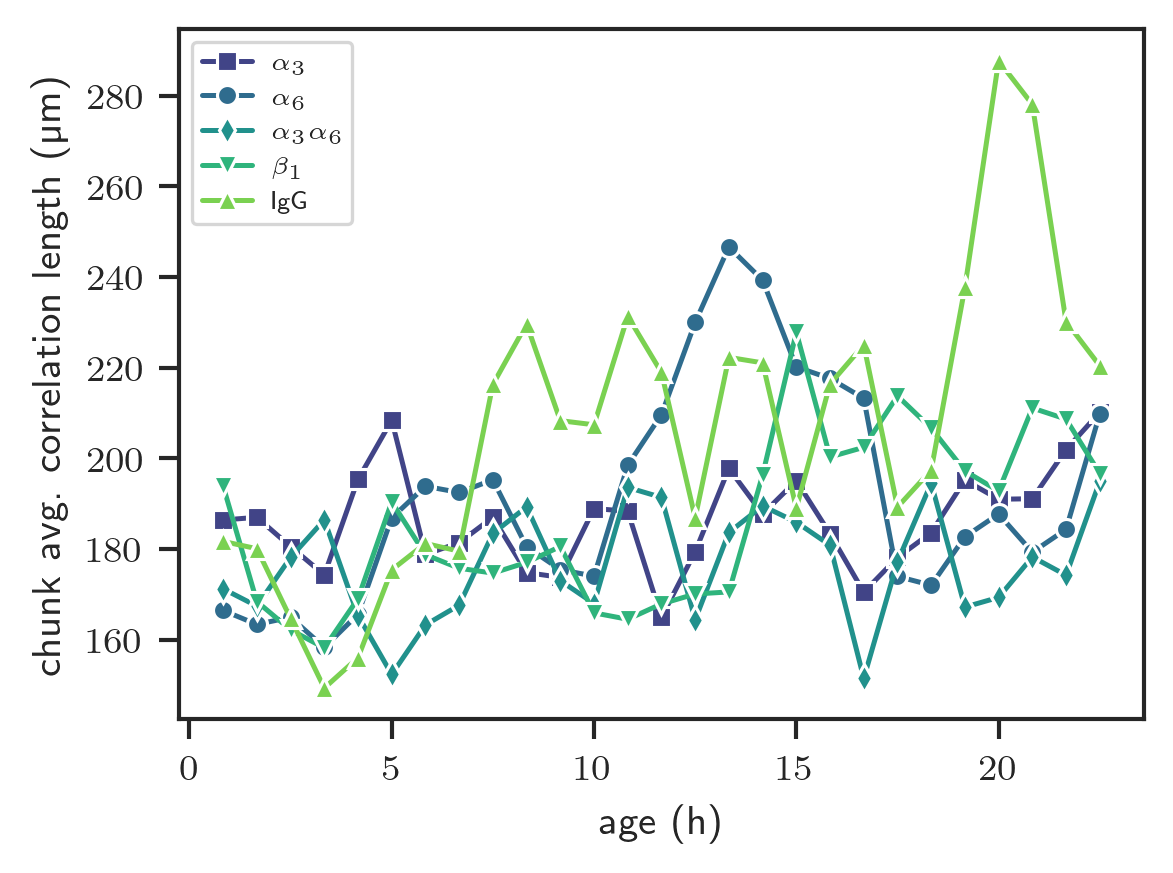

In [190]:
if comparison_plots:
    fig, ax = plt.subplots(figsize=(4, 3))
    comp_space = color_space(len(compare), vmin=0.2, vmax=0.8)

    sns.lineplot(
        data=comp_corr_df, 
        x="age", 
        y="correlation length",  
        markers=symb_space,
        ax=ax,
        style="data",
        dashes=False,
        hue="data",
        palette=comp_space
    )
    ax.set(
        ylabel="chunk avg. correlation length (µm)",
        xlabel="age (h)"
    )
    ax.legend(fontsize=6, loc=0)
    fig.tight_layout()
    fig.savefig(comp_path / "corr_length_evolution.png", bbox_inches="tight", dpi=300)

## 5. Dynamical heterogeneities 

### Setup & functions

In [40]:
from scipy import ndimage

def chunk_avg_spatial_vel(
    u: np.ndarray, 
    v: np.ndarray, 
    fov: int, 
    chunk: np.ndarray, 
    scale: Optional[float] = None
) -> np.ndarray:
    """Compute the average velocity in x and y direction within a chunk for each grid point."""
    if scale is None:
        scale = 1.0
    
    return scale * np.sqrt(u[fov, chunk].mean(axis=0)**2 + v[fov, chunk].mean(axis=0)**2)


def quantile_map(vel: np.ndarray, quantile: float = 0.8) -> np.ndarray:
    """Returns a an image with pixel values of 1 where velocity vectors fall into the quantile and 0 otherwise."""
    fastest = vel[:]
    q = np.quantile(vel.flatten(), quantile)
    fastest[fastest < q] = 0
    fastest[fastest >= q] = 1

    return fastest

def dyn_het_size(
    vel: np.ndarray, 
    quantile: float = 0.8, 
    minsize: Optional[int] = None
) -> tuple[np.ndarray, float, float]:
    """Calculate the average size of velocity clusters that fall into the given quantile.

    Returns an array of sizes, mean size, and standard deviaton of the size.
    If `minsize` is given, all clusters below this size are excluded, e.g. if `minsize` = 2,
    all clusters of size=1 are excluded. The number of clusters returned is also adjusted to 
    the minsize value.
    """
    # create image only containing the velocities for the given quantile
    fastest = vel[:]
    fastest[fastest < np.nanquantile(vel.flatten(), quantile)] = 0

    # create label image
    labeled, nr_clusters = ndimage.label(fastest)

    # set minsize
    minsize = 1 if minsize is None else minsize

    # get sizes of clusters
    sizes = []
    for i in range(1, nr_clusters + 2):
        if (cluster_size := len(labeled[labeled==i])) >= minsize:
            sizes.append(cluster_size)
    sizes = np.array(sizes)

    return sizes, np.sqrt((sizes*4/np.pi).mean()), np.sqrt(sizes*4/np.pi).std()
    

### Visualising the fastest 20% and clusters of dynamical heterogeneity 
from _Angelini et al, PNAS, 2011_

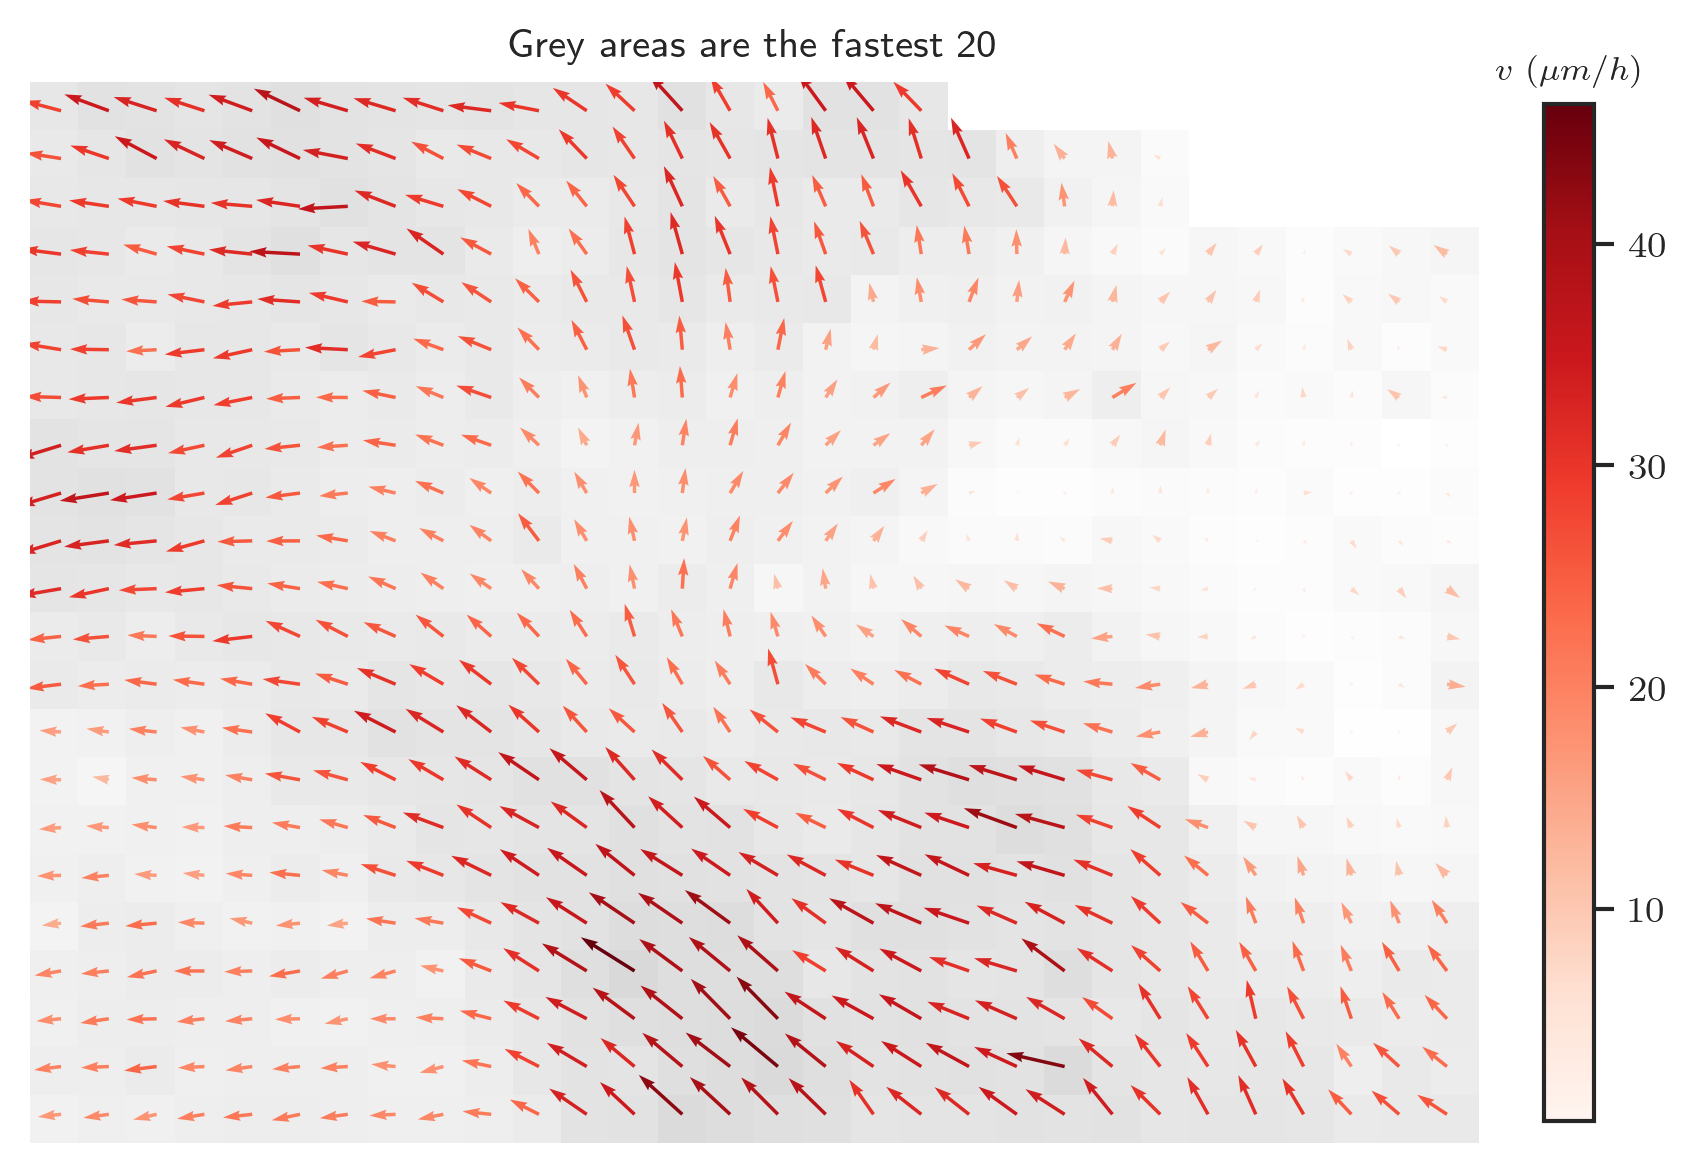

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))
fov, cnum = 0, 0
quantile = 0.8

fastest = quantile_map(
    chunk_avg_spatial_vel(u, v, fov, chunks[cnum], scale=scale),
    quantile=quantile
)

ax.imshow(fastest[::-1], extent=(x.min()/2, x.max() + x.min()/2, y.min()/2, y.max() + y.min()/2), 
           alpha=0.15, cmap=plt.cm.binary)

ax, sp, cb = create_quiverplot(
    ax, x, y,
    u[fov, chunks[cnum]].mean(axis=0) * scale * 3600, 
    v[fov, chunks[cnum]].mean(axis=0) * scale * 3600,
    colorbar=False
)
cb = plt.colorbar(sp, ax=ax, fraction=0.031, pad=0.04)
ax.axis('off')
cb.ax.set_title(r"$v\ (\mu m/h)$", fontsize=8)
ax.set_title(f"Grey areas are the fastest {(1-quantile) * 100:.0f}% | chunk {cnum}, {config['plotpath']}")
fig.tight_layout()
fig.savefig(plotpath / "example-fastest-percentile", bbox_inches="tight")

### Measuring cluster size over time

In [42]:
size_dist = []
minsize = 1

dyn_het_res = np.zeros((len(images), len(chunks), 3))
for i in range(len(images)):
    fov_size_dist = []
    for j in range(len(chunks)):
        _vel = chunk_avg_spatial_vel(u, v, i, chunks[j])
        sizes, mean, std = dyn_het_size(_vel, minsize=minsize)
        fov_size_dist.append(sizes)
        dyn_het_res[i, j] = len(sizes), mean, std
    size_dist.append(fov_size_dist[:])

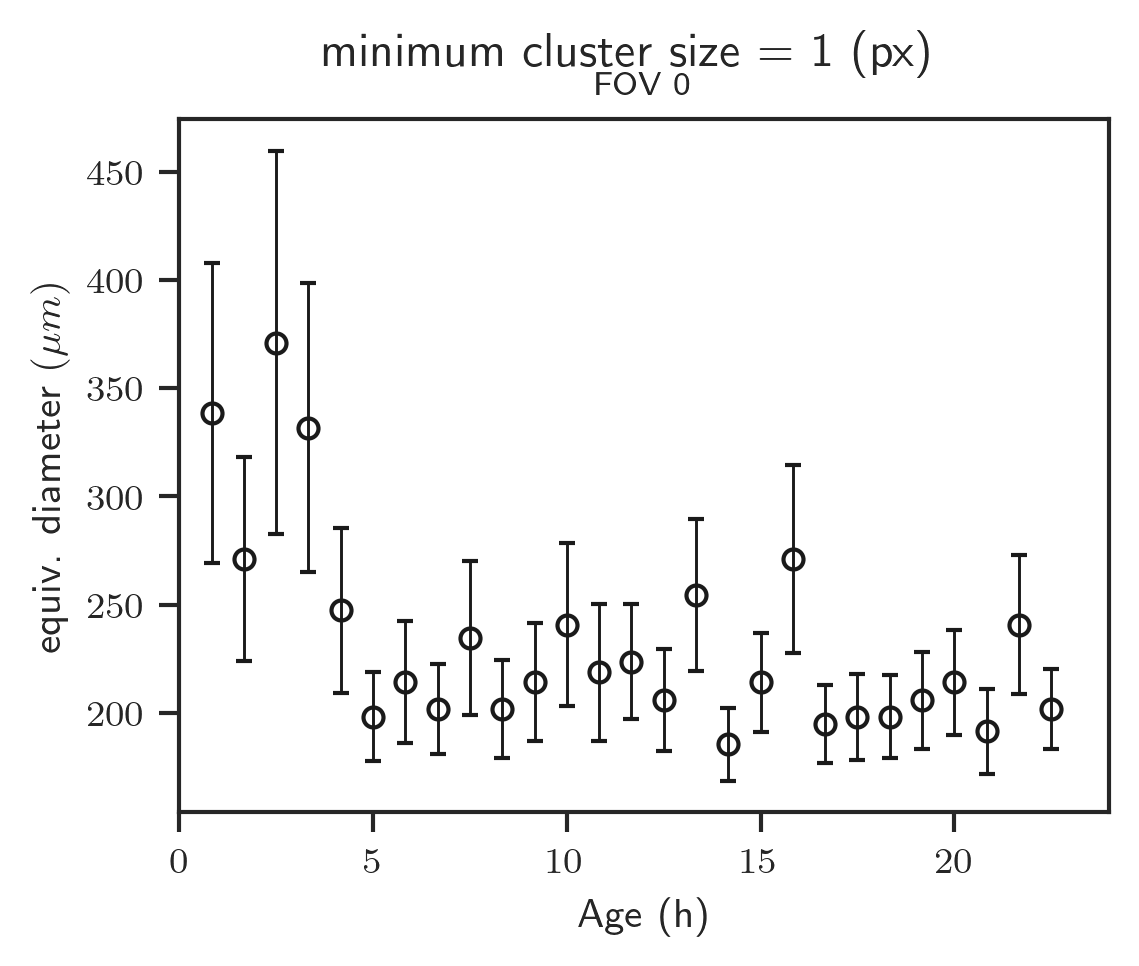

In [43]:
piv_pixel_area = x.min() * y.min() * 1e6 # µm^2/px



fig, ax = plt.subplots(figsize=(4, 3))
i = 0
n, mean, std = dyn_het_res[i].T

ax.errorbar(age, mean*np.sqrt(piv_pixel_area), yerr=std/np.sqrt(n)*np.sqrt(piv_pixel_area), 
            marker="o", markerfacecolor="None", lw=0, elinewidth=0.7, 
            capsize=2, ecolor="k", zorder=0, color="k")
ax.set_title(f"FOV {i}", fontsize=8)
#ax.plot(age, dyn_het_res.T[1].mean(axis=1)*np.sqrt(piv_pixel_area), ls="--", color="tab:red")
    
# sc = ax.scatter(age, mean,, marker="o", zorder=100, vmax=age.max(), vmin=age.min())
# plt.colorbar(sc, ax=ax)
ax.set_ylabel(r"equiv. diameter $(\mu m)$")
ax.set_xlabel("Age (h)")
ax.set_xlim(0, 24)

fig.suptitle(f"minimum cluster size = {minsize} (px)")
fig.savefig(plotpath / "avg-dyn-het-cluster-size-fov", bbox_inches="tight")

### Presence correlation between cluster size & correlation length? 

In some cases (depending on the settings of the PIV interrogation window size) the cluster size and correlation length may measure similar things so having a look if they correlate might be interesting.

In [44]:
def line(x, k, d):
    return k*x + d

linear_model = lm.Model(line)
linear_model.set_param_hint("k", value=1)
linear_model.set_param_hint("d", value=0)
corr_len_equiv_diam = pd.DataFrame(columns=["correlation length", "equivalent diameter", "chunk"])

for i in range(len(corrlen)):
    _df = pd.DataFrame(data={
        "correlation length": np.array([np.nanmean(corrlen[i][chunk]) for chunk in chunks])*scale,
        "equivalent diameter": dyn_het_res[i].T[1] * np.sqrt(piv_pixel_area),
        "chunk": np.arange(len(chunks))
    })

    corr_len_equiv_diam = pd.concat([corr_len_equiv_diam, _df])

linear_model_results = linear_model.fit(
    data=corr_len_equiv_diam["equivalent diameter"], 
    x=corr_len_equiv_diam["correlation length"],
)

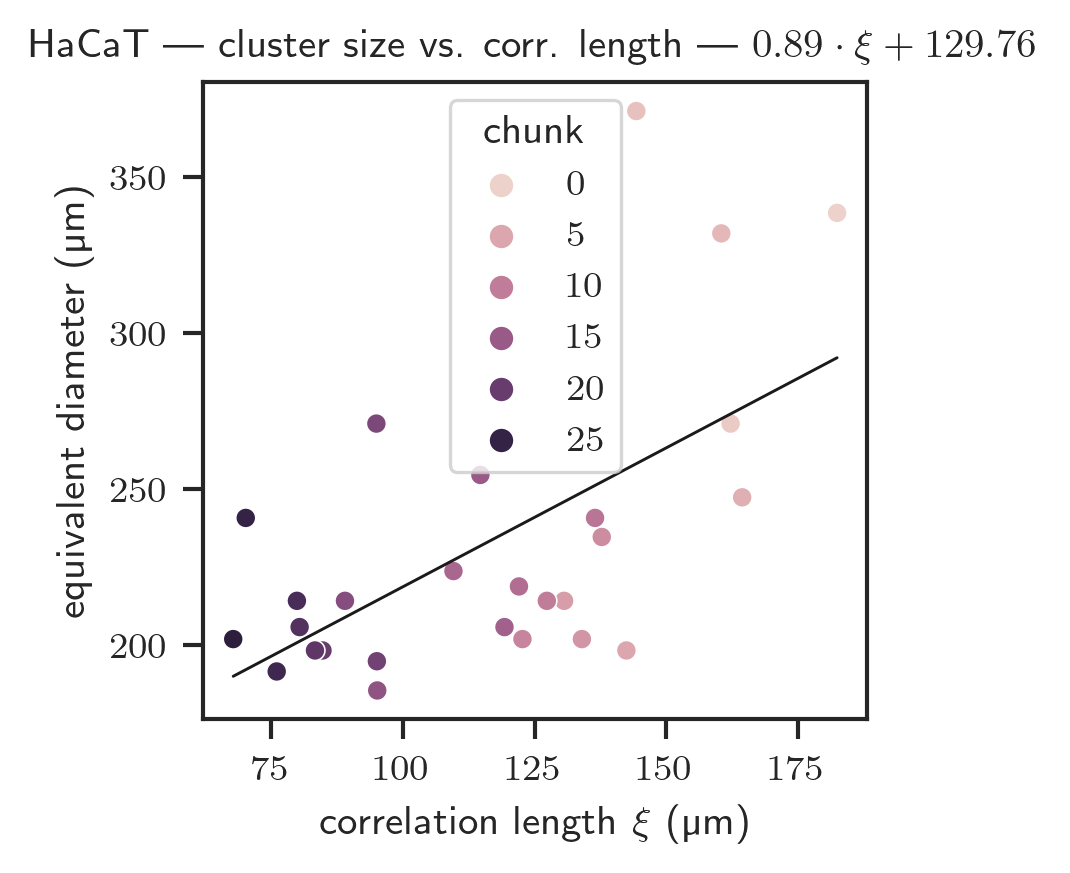

In [45]:
fig = plt.figure(figsize=(3, 3))

sp = sns.scatterplot(
    data=corr_len_equiv_diam, 
    x="correlation length", 
    y="equivalent diameter", 
    hue="chunk"
)

fit_x = np.linspace(corr_len_equiv_diam['correlation length'].min(), corr_len_equiv_diam['correlation length'].max())

sp.axes.plot(
    fit_x, 
    linear_model.eval(x=fit_x, **linear_model_results.best_values),
    lw=0.7,
    color="k",
    # label=r"${k:.2f}\cdot \xi + {d:.2f}$".format(**linear_model_results.best_values)
)

sp.axes.set(
    xlabel=r"correlation length $\xi$ (µm)",
    ylabel="equivalent diameter (µm)",
    title=f"{config['plotpath']} | cluster size vs. corr. length | " + r"${k:.2f}\cdot \xi {d:+.2f}$".format(**linear_model_results.best_values),
)

fig.tight_layout()
fig.savefig(plotpath / "cluster-size-vs-corrlen", bbox_inches="tight")

## 6. Alignment maps
cell cultures are always chaotic neutral.

as defined in _Malinverno et al., 2017_ , let's inspect the alignment index defined as:
$$
    a(\vec{r}) = \frac{\vec{v}(\vec{r})\cdot \vec{v}_0}{\lvert \vec{v}(\vec{r})\rvert \cdot \lvert \vec{v}_0\rvert},\ \vec{v}_0 \equiv \langle \vec{v}(\vec{r})\rangle_\vec{r}\  \text{of the frame in question}
$$

### setup & functions

In [46]:
def alignment_index(u: np.ndarray, v: np.ndarray) -> np.ndarray:
    """Calculate the alignment index.

    See Malinverno et al., 2017.
    """
    u_0 = np.nanmean(u, axis=(-2, -1))
    v_0 = np.nanmean(v, axis=(-2, -1))
    
    u_shape_equiv = np.ones(len(u.shape), dtype=np.int8)
    u_shape_equiv[:len(u_0.shape)] = u_0.shape
    
    norm = np.sqrt(u**2 + v**2) * np.sqrt(u_0**2 + v_0**2).reshape(u_shape_equiv)
    
    return (u * u_0.reshape(u_shape_equiv) + v * v_0.reshape(u_shape_equiv)) / norm

alignment per chunk

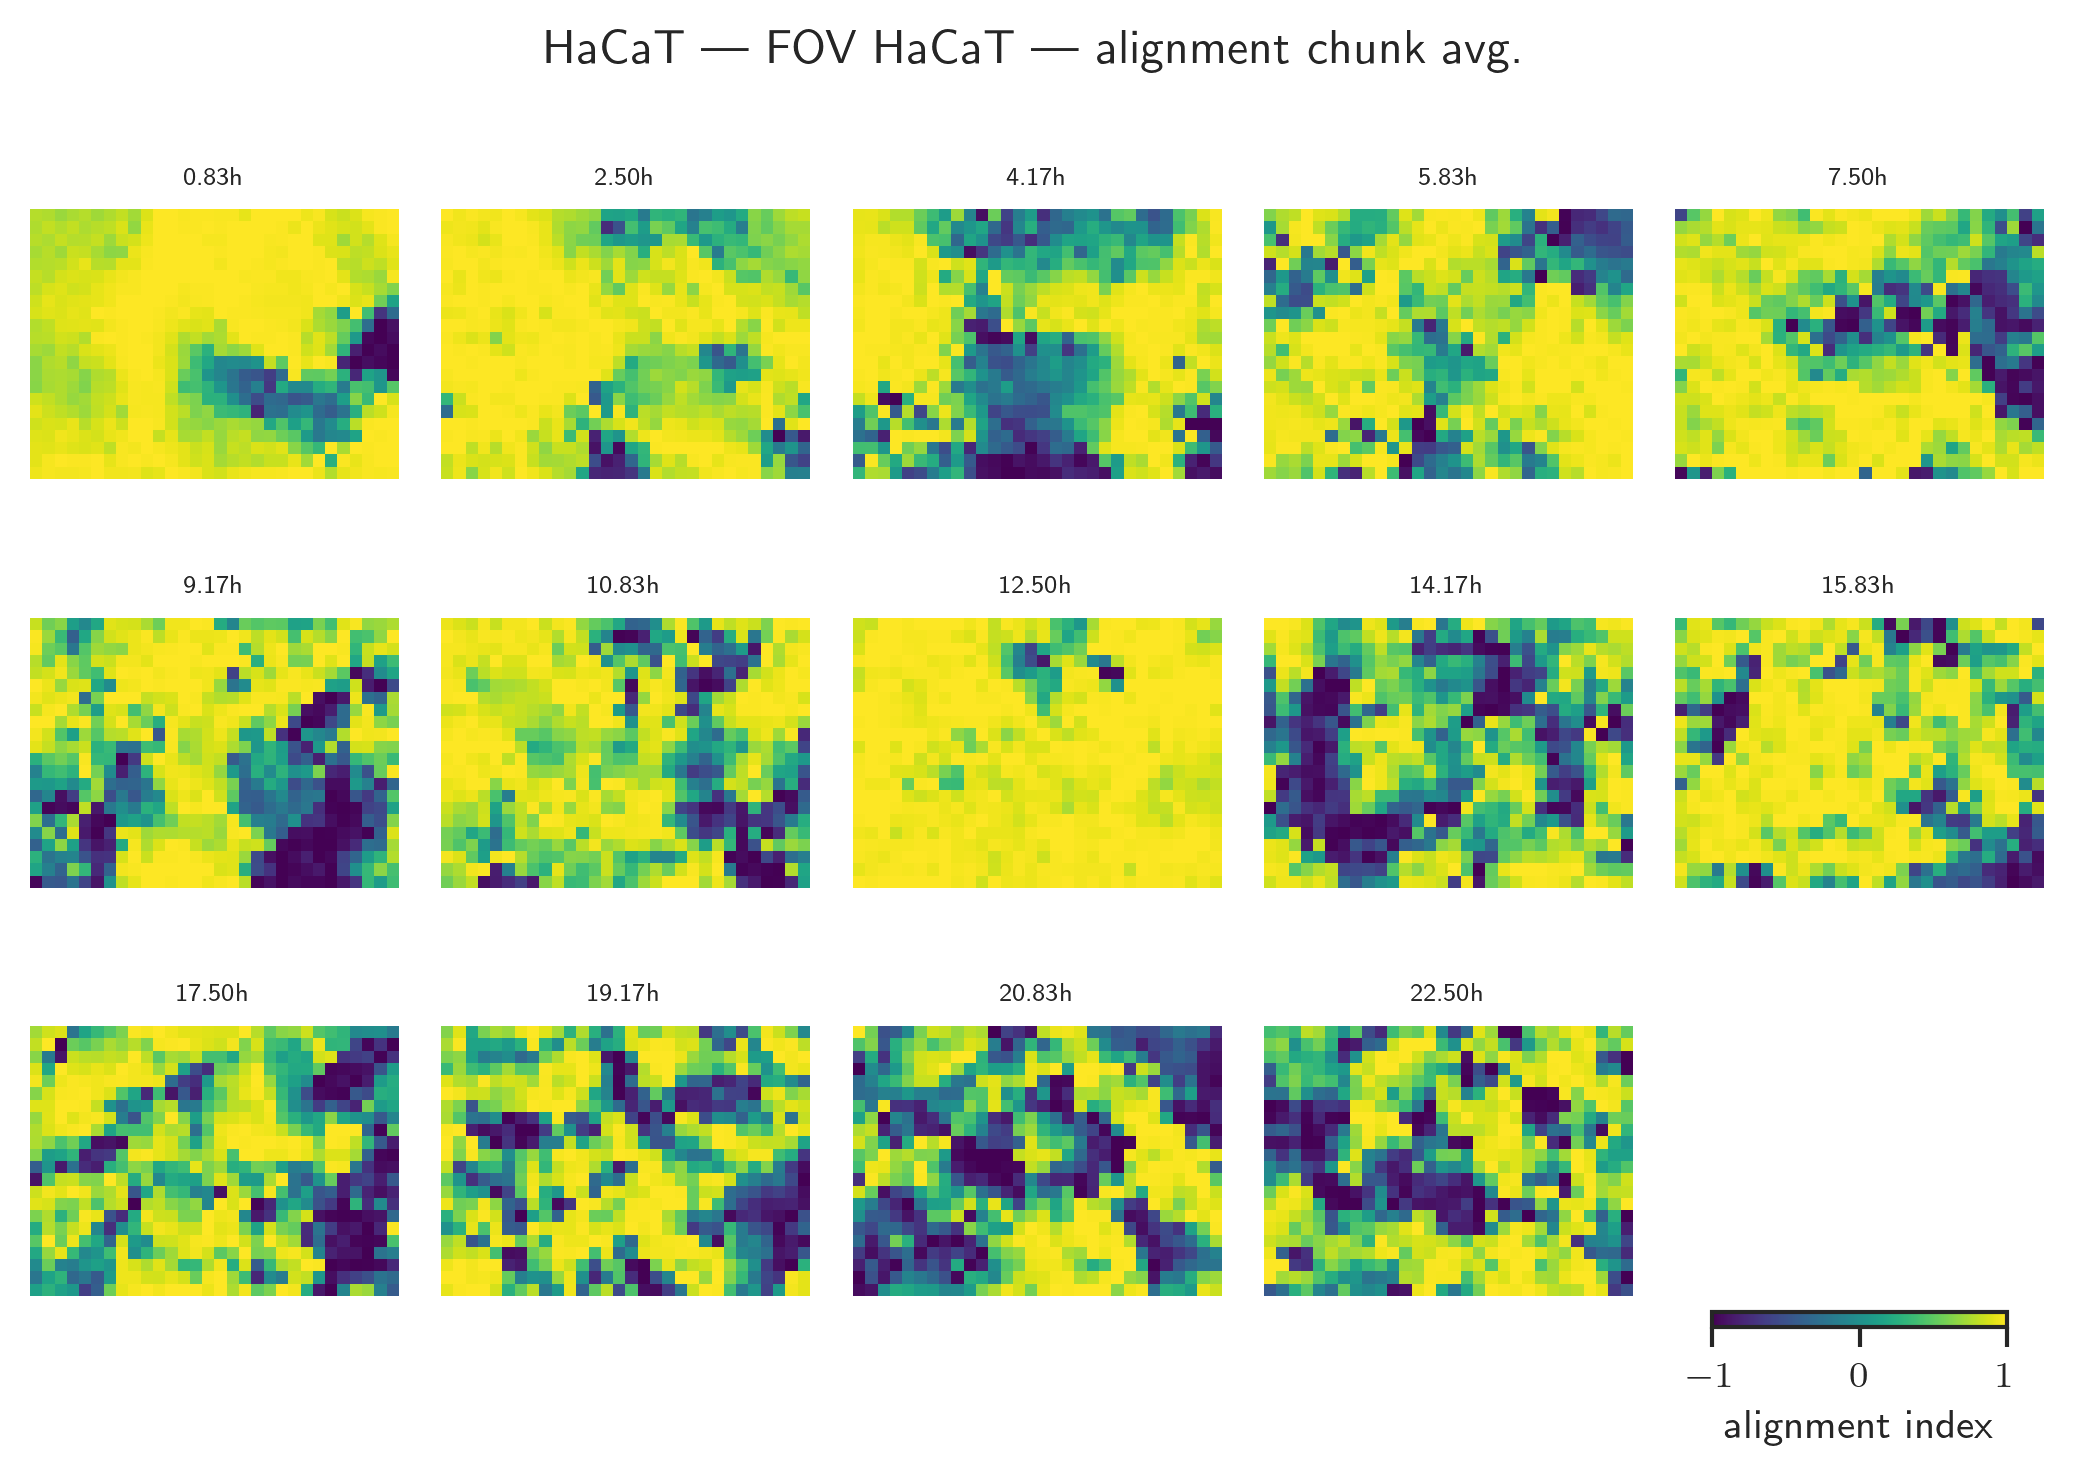

In [47]:
fov = 0

fig, axes = plt.subplots(3, 5, figsize=(7, 5))
ai = np.array([alignment_index(
        np.nanmean(u[fov][chunk], axis=0) * scale * 3600, 
        np.nanmean(v[fov][chunk], axis=0) * scale * 3600
    ) for chunk in chunks])

for i, ax in enumerate(axes.flatten()):
    i = i*2
    if i >= len(chunks):
        ax.axis('off')
        continue
    im = ax.imshow(
        ai[i],
        # ai[fov][chunks[i]].mean(axis=0), 
        vmin=-1, vmax=1, cmap=plt.cm.viridis)
    ax.set_title(f"{age[i]:.2f}h", fontsize=6)
    ax.axis('off')
plt.colorbar(im, ax=axes.flatten()[-1], location='bottom', shrink=0.8, label="alignment index")
fig.suptitle(f"{config['plotpath']} | FOV {config['plotpath']} | alignment chunk avg.")
fig.tight_layout()
fig.savefig(plotpath / "example-alignment.png", bbox_inches="tight")

Only plot particular ages.

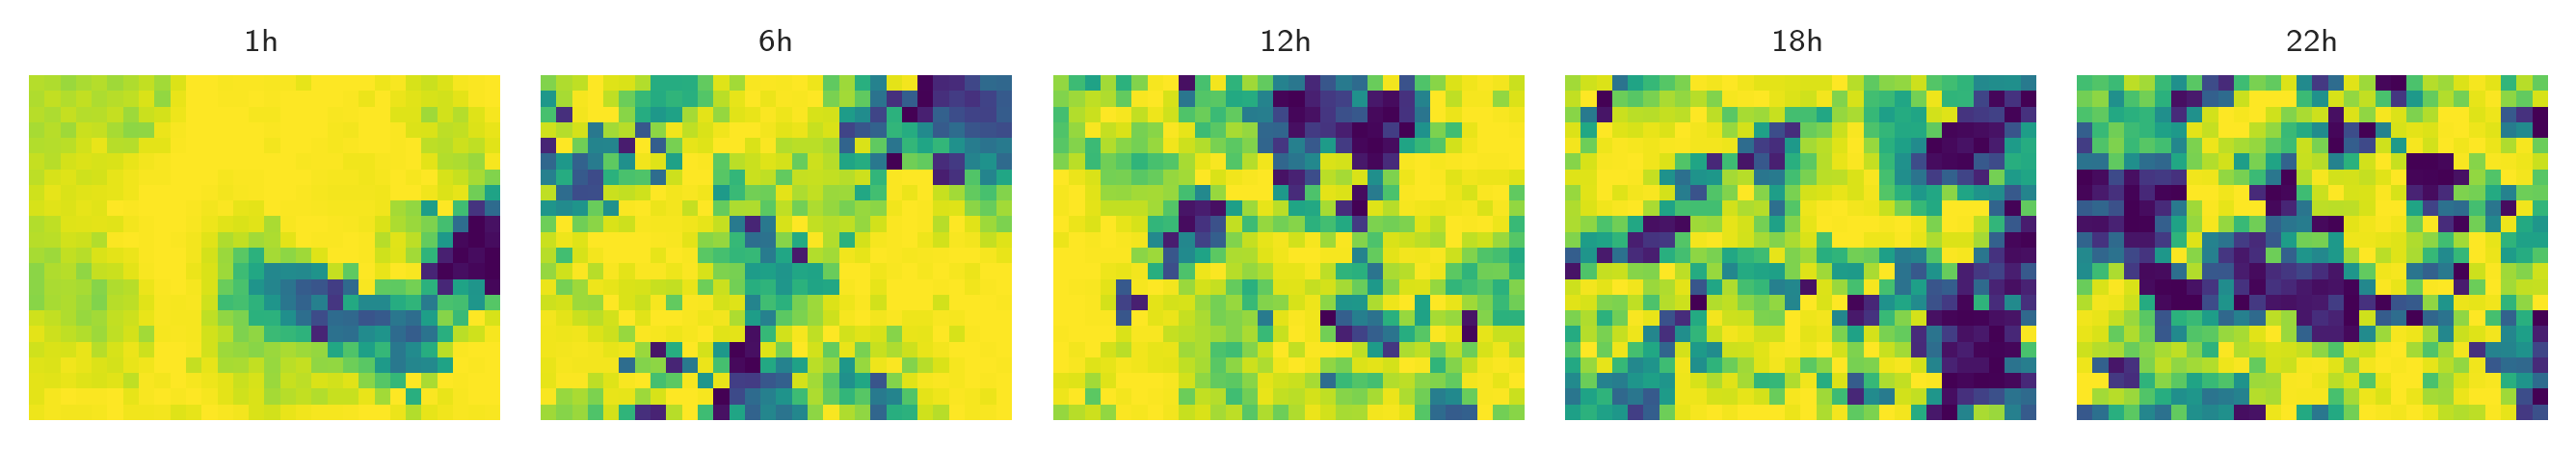

In [48]:
fov = 0

fig, axes = plt.subplots(1, 5, figsize=(9, 3))

selected_chunks = [0, len(chunks)//4, len(chunks)//2, len(chunks)*3//4, -1]

for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(
        ai[selected_chunks[i]], 
        vmin=-1, vmax=1, 
        cmap=plt.cm.viridis
    )
    ax.set_title(f"{age[selected_chunks[i]]:.0f}h", fontsize=8)
    ax.axis('off')
# plt.colorbar(im, ax=axes.flatten()[-1], location='bottom', shrink=0.8, label="alignment index")
# fig.suptitle(f"{config['plotpath']} | FOV {config['plotpath']} | alignment chunk avg.")
fig.tight_layout()
fig.savefig(plotpath / f"alignment-{config['type']}.pdf", format="pdf", bbox_inches="tight", dpi=600)

In [49]:
# define a function after defining age
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

def inset_cb(
    ax: plt.Axes,  # correct type?
    bounds: list[float], 
    vmin: float = -1,
    vmax: float = 1,
    cmap = plt.cm.viridis, 
    orientation: str = 'horizontal', 
    ticklocation='bottom',
    label="alignment index"
):
    """Create an inset colorbar."""
    inset = ax.inset_axes(bounds)  # x0, y0, width, height
    cb = ColorbarBase(
        inset, cmap=cmap,
        norm=Normalize(vmin=vmin, vmax=vmax),
        orientation=orientation, ticklocation=ticklocation,
        
    )
    cb.set_label(label)
    # cb.ax.tick_params(axis='y', direction='in')

    return cb


# set this to True if you want to just produce the standalone colorbar for the alignment index as a pdf
if False:
    fig, ax = plt.subplots(figsize=(1.3, 0.3))
    ax.axis("off")
    cb = inset_cb(
        ax,
        bounds=[0, 0, 1, 0.3],
    )
    # fig.tight_layout()
    fig.savefig(plotpath / "alignment-index-colorbar.pdf", format="pdf", dpi=300, bbox_inches="tight")

alignment index over time

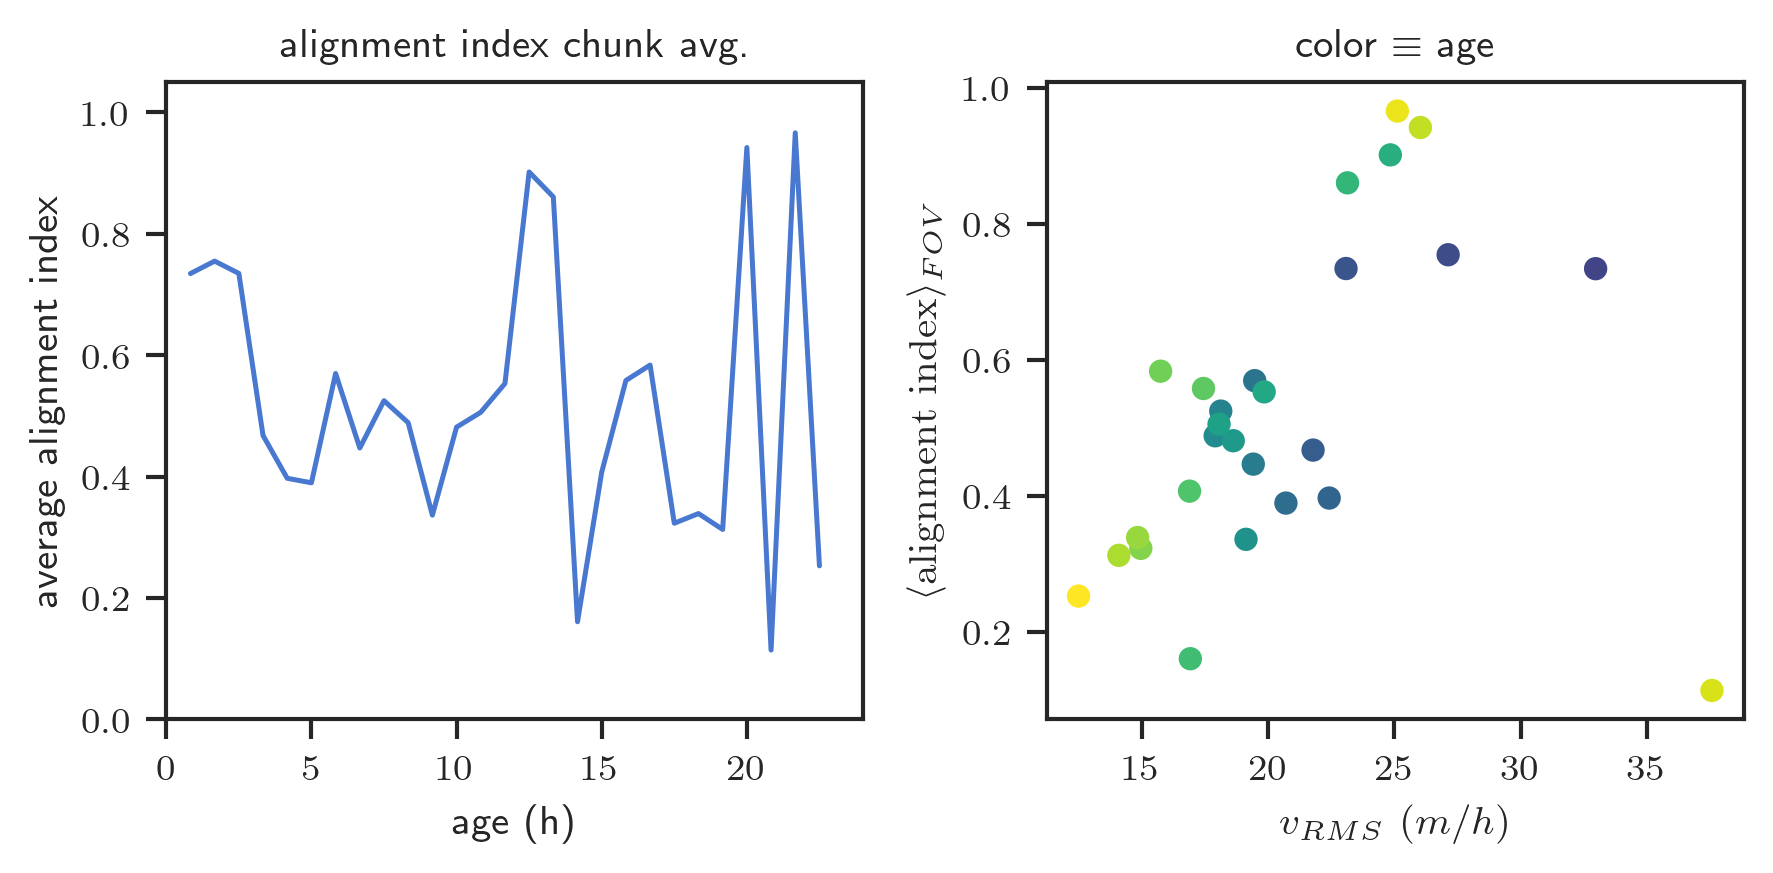

In [50]:
ai_df = pd.DataFrame(columns=[
    "ai",
    "fov",
    "age"
]
)

for ifov in range(len(images)):
    ai_df = pd.concat(
        [ai_df, 
         pd.DataFrame(data={
            "ai": np.array([alignment_index(
                np.nanmean(u[ifov][chunk], axis=0) * scale, 
                np.nanmean(v[ifov][chunk], axis=0) * scale
            ) for chunk in chunks]).mean(axis=(-2, -1)),
            "fov": [ifov+1] * len(chunks),
            "age": age
        })])

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
ax = axes[0]
sns.lineplot(data=ai_df, x="age", y="ai", errorbar="sd", ax=ax)
ax.set(
    ylim=(0, 1.05),
    xlim=(0, 24),
    ylabel="average alignment index",
    xlabel="age (h)",
    title="alignment index chunk avg."
)

ax = axes[1]
ax.scatter(
    total_vrms*scale*3600,
    ai_df.groupby("age")['ai'].mean().to_numpy(),
    c=color_space(len(total_vrms)),
)

line = lambda x, k, d: k*x + d

lin_mod = lm.Model(line)
lin_mod.set_param_hint("k", value=1.0)
lin_mod.set_param_hint("d", value=0.0)

res = lin_mod.fit(
    ai_df.groupby("age")['ai'].mean().to_numpy(),
    x=total_vrms*scale*3600
)
fit_range = np.linspace((total_vrms*scale*3600).min(), (total_vrms*scale*3600).max())
# ax.plot(fit_range, res.eval(x=fit_range), lw=0.7, ls="--", color="k",
#        label=r"${k:.2f}\cdot\ v_{{RMS}} {d:+.2f}$".format(**res.best_values))
# ax.legend(fontsize=8)
ax.set(
    xlabel=r"$v_{RMS}\ (µm/h)$",
    ylabel=r"$\langle \mathrm{alignment\ index}\rangle_{FOV}$",
    title="color $\equiv$ age"
)

fig.tight_layout()
fig.savefig(plotpath / "alignment-index-evo.png", bbox_inches="tight")

## 7. Instantaneaus order parameter $\psi(t)$

as defined in *Malinverno et al. 2017*:
$$
    \psi(t) = \frac{1}{M} \sum_{j=1}^M \frac{\lvert \langle \vec{v}(t)\rangle_j \rvert^2}{\langle \lvert \vec{v}(t)\rvert^2\rangle_j},\ M=\# FOV
$$

In [51]:
def instantaneous_order_parameter(u: np.ndarray, v: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Calculate the instantaneous order parameter psi(t) as defined in Malinverno et al. 2017.

    `u`, `v` are assumed to have shape (nfovs, t, y, x).
    """
    # first the absolute square of the spatial average 
    abs_squ_avg = u.mean(axis=(-2, -1))**2 + v.mean(axis=(-2, -1))**2

    # second the spatial average of the absolute square
    avg_abs_squ = (u**2 + v**2).mean(axis=(-2, -1))

    # finally average over all fields of view
    return np.nanmean(abs_squ_avg / avg_abs_squ, axis=0), np.nanstd(abs_squ_avg / avg_abs_squ, axis=0)# .mean(axis=0)


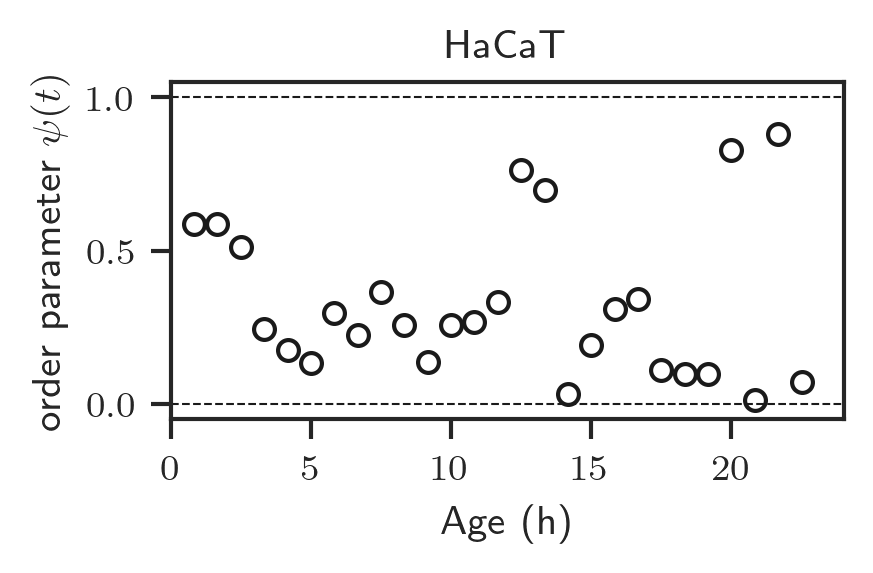

In [52]:
psi = [
    instantaneous_order_parameter(
        np.nanmean(u[:, chunk], axis=1),
        np.nanmean(v[:, chunk], axis=1)
    ) for chunk in chunks
]


psi, psi_std = np.array(psi).T
psi_df = pd.DataFrame(
    data={
        "psi": psi,
        "psi std": psi_std,
        "age": age
    }
)
# store data
psi_df.to_pickle(datapath / "order-results.pkl")


fig, ax = plt.subplots(figsize=(3, 2))
ax.errorbar(
    age,
    psi,
    yerr=psi_std,
    marker="o",
    markersize=5,
    linewidth=0, 
    elinewidth=1,
    markerfacecolor="None",
    markeredgecolor="k",
    ecolor="tab:red"
)
ax.set(
    ylim=(-0.05, 1.05),
    xlim=(0, 24),
    ylabel=r"order parameter $\psi(t)$",
    xlabel="Age (h)",
    title=f"{config['plotpath']}",
)
ax.axhline(0, ls="--", lw=0.5, color="k")
ax.axhline(1, ls="--", lw=0.5, color="k")

fig.tight_layout()
fig.savefig(plotpath / "instantaneous-order-param.png", bbox_inches="tight")

In [53]:
if comparison_plots:
    comp_path = (Path("piv") / compare[0]).parent / "comparison"
    comp_path.mkdir(parents=True, exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(4, 2))
    # error_norm = np.sqrt([len(ch) for ch in chunks])
    
    config = read_config(configpath, verbose=False)

    comp_space = color_space(len(compare), vmin=0.2, vmax=0.8)
    symb_space = ["s", "o", "d", "v", "^"]

    # empty DataFrame for collecting results
    comp_psi_df = pd.DataFrame()
    
    # load, calculate and plot the RMS velocities
    for i, cpath in enumerate(compare):
        # filename
        cfile = Path("piv") / cpath / "data/order-results.pkl"

        # load data
        cdata = pd.read_pickle(cfile)
        cdata["data"] = [cpath] * len(cdata)

        # stack with collection df
        comp_psi_df = pd.concat([comp_psi_df, cdata], ignore_index=True)

    # plot the result
    sp = sns.lineplot(
        data=comp_psi_df, 
        x="age", 
        y="psi",  
        markers=symb_space,
        ax=ax,
        style="data",
        dashes=False,
        hue="data",
        palette=comp_space
    )

    ax.set(
        ylim=(-0.05, 1.2),
        xlim=(0, 24),
        ylabel=r"order parameter $\psi(t)$",
        xlabel="Age (h)",
    )
    ax.axhline(0, ls="--", lw=0.5, color="k")
    ax.axhline(1, ls="--", lw=0.5, color="k")
    
    ax.legend(fontsize=5, ncol=3, loc=1)
    fig.savefig(comp_path / "order_comparison.png", bbox_inches="tight", dpi=300)


order parameter and alignment index also often appear to be correlated, which may be interesting?

[Text(0.5, 0, 'order parameter'),
 Text(0, 0.5, 'avg. alignment index'),
 Text(0.5, 1.0, 'color $\\equiv$ age')]

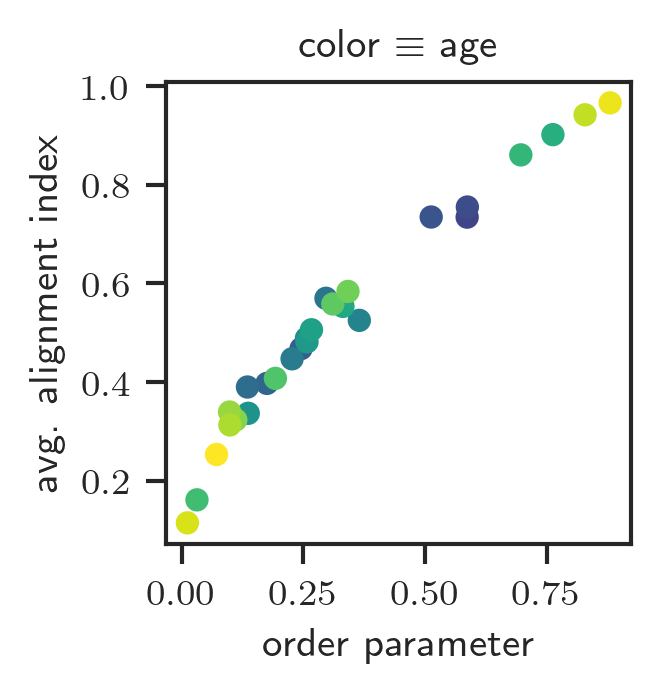

In [54]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(psi, ai_df.groupby("age")['ai'].mean().to_numpy(), c=color_space(len(psi)))
ax.set(
    xlabel="order parameter",
    ylabel="avg. alignment index", 
    title="color $\equiv$ age"
)